<a href="https://colab.research.google.com/github/narendrapatel6321-dotcom/Diabetes-Classification/blob/main/Diabetes_Prediction_3_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Importing Libraries

In [ ]:
# Core Libraries
import numpy as np
import pandas as pd
import joblib

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing Modules from Scikit-learn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
    FunctionTransformer,
    LabelEncoder
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Machine Learning Models
from sklearn.linear_model import (
    LogisticRegression,
    LinearRegression,
    ElasticNet
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
    GradientBoostingRegressor,
    VotingClassifier,
    StackingClassifier,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Model Selection & Evaluation Metrics
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    StratifiedKFold
)

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay,
    roc_curve,
    mean_absolute_error,
    precision_recall_curve,
    average_precision_score,
    f1_score,
    recall_score
)

from sklearn.inspection import permutation_importance
from sklearn.base import clone

# External Libraries (installed if not present)
try :
  import gdown
except ModuleNotFoundError:
  !pip install gdown
  import gdown

try :
  import optuna
except ModuleNotFoundError:
  !pip install optuna
  import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 10.6 MB/s eta 0:00:00


#2. Downloading Data

In [ ]:
def load_data(file_id : str,output_filename : str):
  """
  Downloads a file from Google Drive and returns a Pandas DataFrame.
  Args:
    file_id: The ID of the file to download.
    output_filename: The name of the file to save the downloaded data as.
  """

  gdrive_url = f'https://drive.google.com/uc?id={file_id}'

  try:
    gdown.download(gdrive_url, output_filename, quiet=False)
    print(f"Successfully downloaded '{output_filename}'")

    df = pd.read_csv(output_filename)
    return df

  except Exception as e:
    print(f"Error downloading file: {e}")
    print('''Please ensure the file ID is correct and the file is publicly shared or accessible to your account.''')

In [ ]:
file_id = '1EHficGxWS0h4pc5zpqDsPZYnZRGg47ht'
output_filename = 'diabetes_data.csv'
df = load_data(file_id,output_filename)

Downloading...
From: https://drive.google.com/uc?id=1EHficGxWS0h4pc5zpqDsPZYnZRGg47ht
To: /content/diabetes_data.csv
100%|██████████| 14.4M/14.4M [00:00<00:00, 127MB/s]


Successfully downloaded 'diabetes_data.csv'


#3. Basic Data Exploration

## 3.1 Data Overview

In [ ]:
df.head()

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,52,125,160,137,184,12.74,7.20,23.5,Type 2,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 31 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   age                                 100000 non-null  int64  
 1   gender                              100000 non-null  object 
 2   ethnicity                           100000 non-null  object 
 3   education_level                     100000 non-null  object 
 4   income_level                        100000 non-null  object 
 5   employment_status                   100000 non-null  object 
 6   smoking_status                      100000 non-null  object 
 7   alcohol_consumption_per_week        100000 non-null  int64  
 8   physical_activity_minutes_per_week  100000 non-null  int64  
 9   diet_score                          100000 non-null  float64
 10  sleep_hours_per_day                 100000 non-null  float64
 11  screen_time_hours_per_day  

## 3.2 Categorical Feature Conversion

In [ ]:
def get_cols(df ,d_type) -> list :
  """
  Returns a list of column names from a Pandas DataFrame that have a specific data type.
   """
  return list(df.select_dtypes(include = d_type).columns)


In [ ]:
object_cols = get_cols(df,object)

In [ ]:
def obj_to_cat(df,object_cols) :
    """
    Converts specified columns in a Pandas DataFrame to categorical data type.
    """
    for col in object_cols :
      df[col] = df[col].astype('category')
    return df


In [ ]:
df = obj_to_cat(df,object_cols)

#4. Diabetes Risk Score Prediction

##4.1 Selecting input features and target for model 1

In [ ]:
features_for_prediction_1 = ['age','gender','ethnicity',
                          'education_level','income_level',
                          'employment_status' , 'smoking_status' ,
                          'alcohol_consumption_per_week' ,
                          'physical_activity_minutes_per_week',
                          'diet_score' , 'sleep_hours_per_day' ,
                          'screen_time_hours_per_day' ,
                          'family_history_diabetes' , 'hypertension_history' ,
                          'cardiovascular_history' , 'bmi' , 'waist_to_hip_ratio' ,
                          'systolic_bp' , 'diastolic_bp' , 'heart_rate' ]
feature_to_predict_1 = 'diabetes_risk_score'

##4.2 Splitting Data

In [ ]:
X_1 = df[features_for_prediction_1]
y_1 = df[feature_to_predict_1]

In [ ]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1,y_1,
                                                            test_size=0.15,
                                                            shuffle=True,
                                                            random_state = 108)

## 4.3 Exploring Training Data

In [ ]:
categorical_cols = get_cols(X_train_1,'category')
numerical_cols = get_cols(X_train_1,np.number)

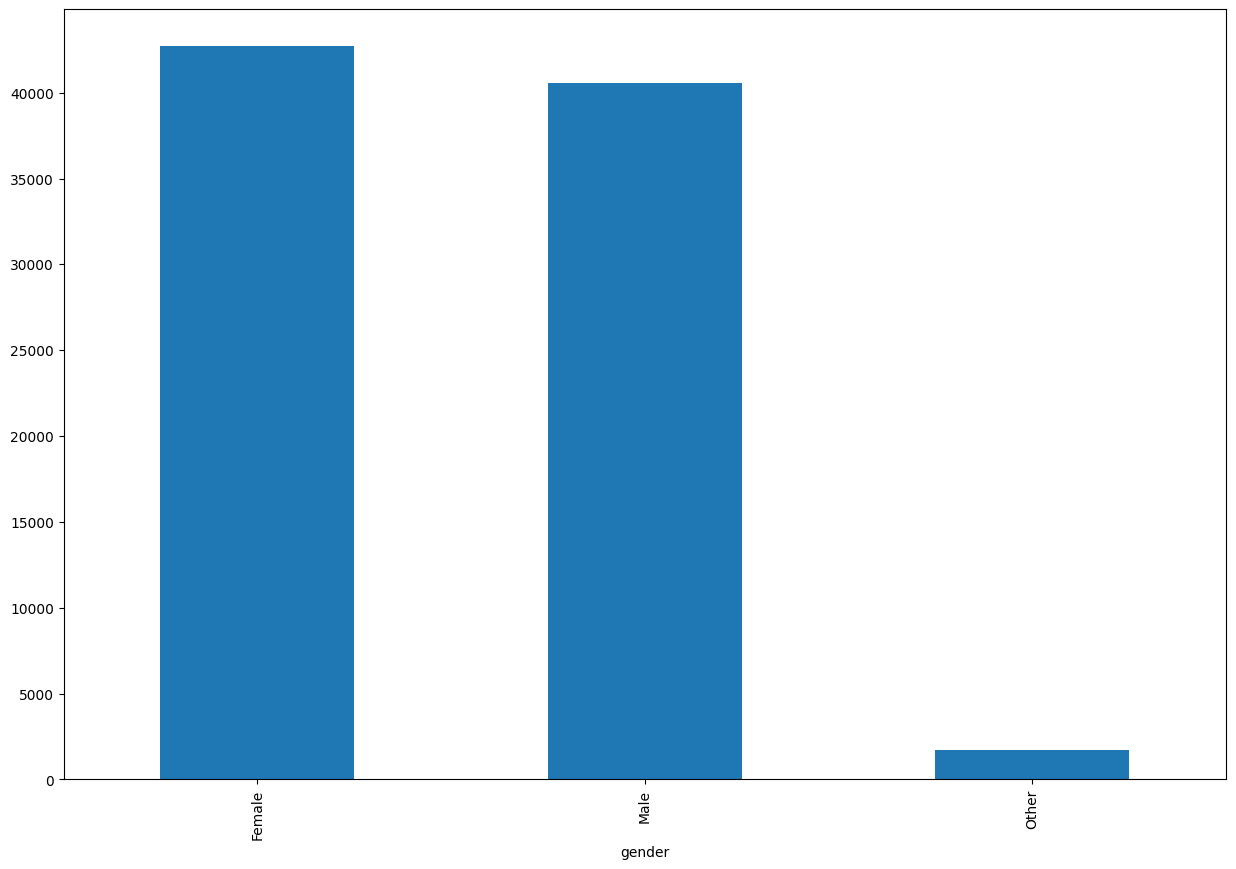

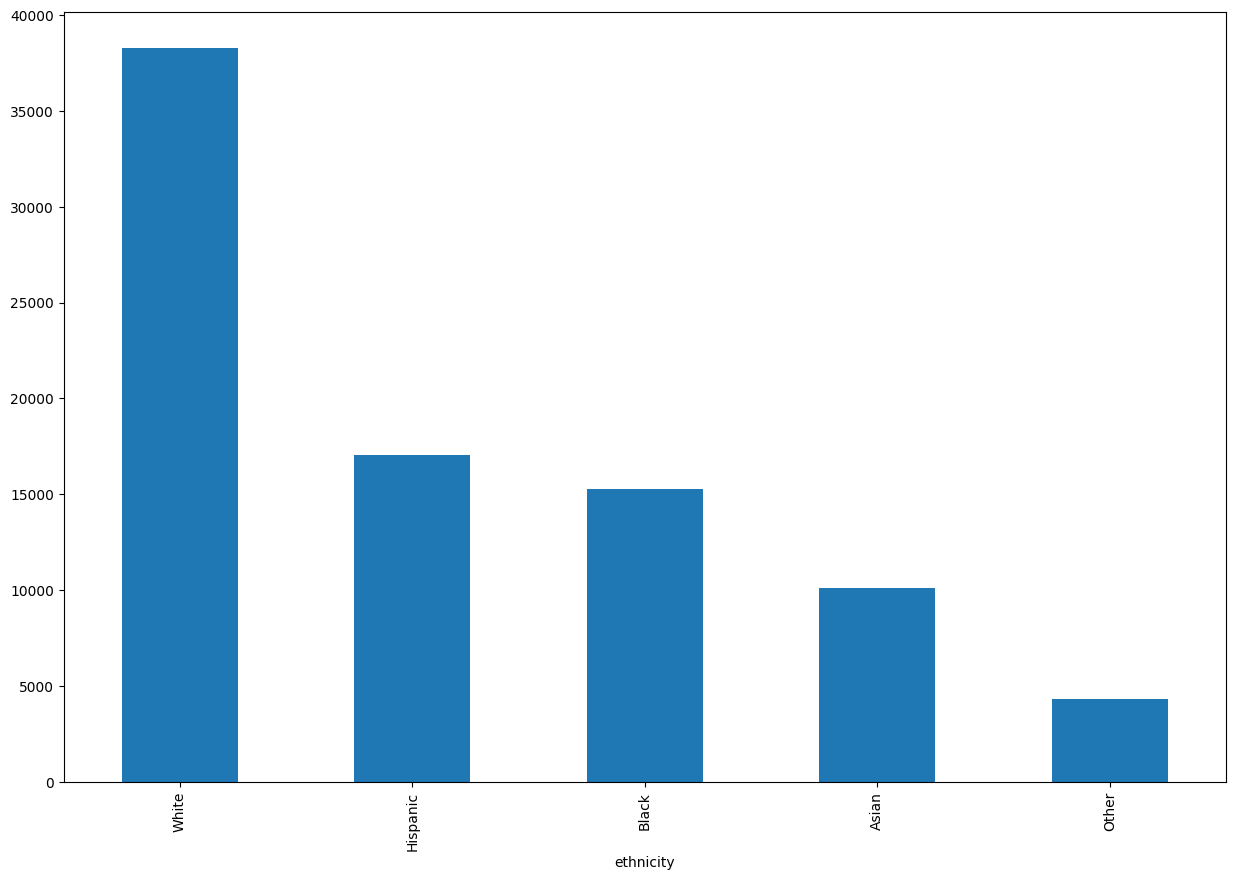

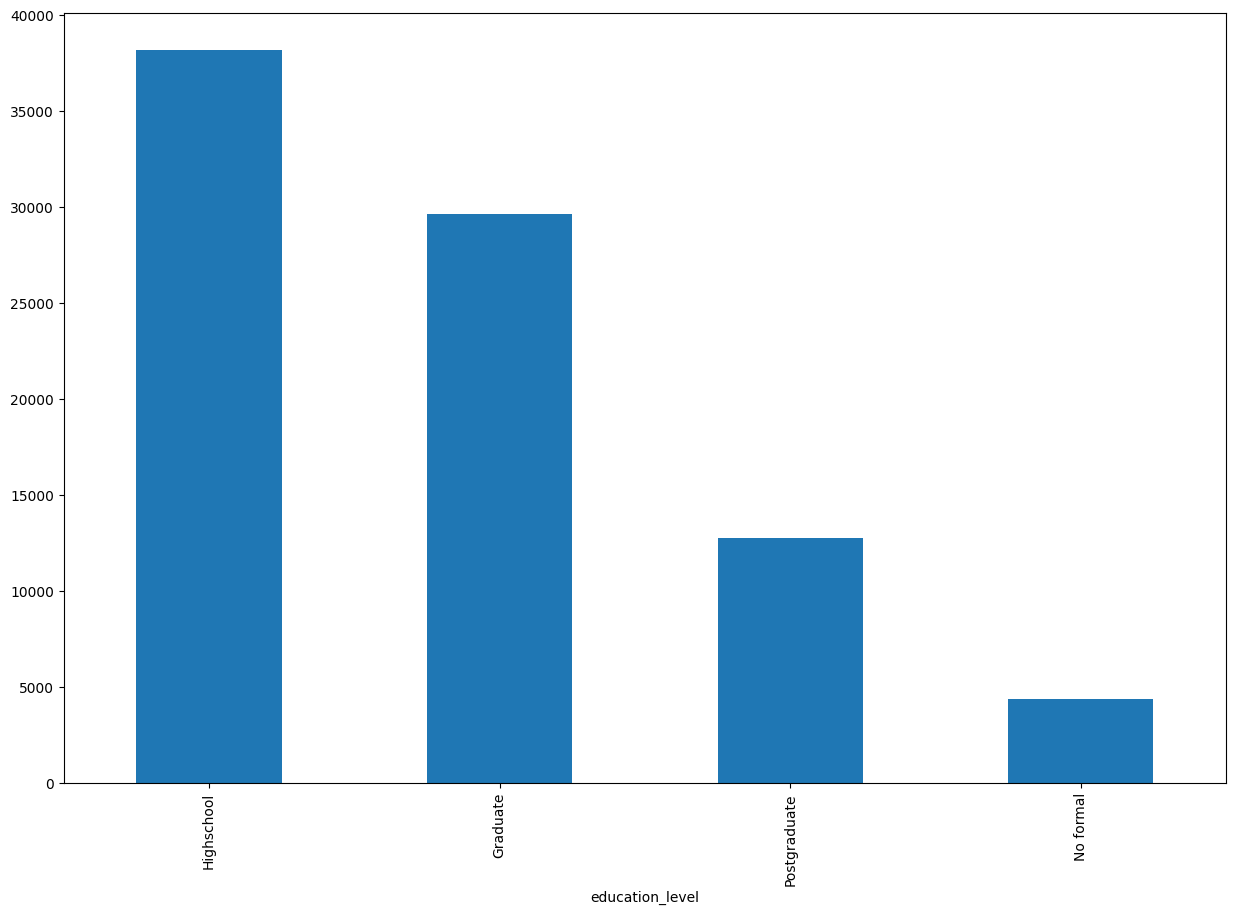

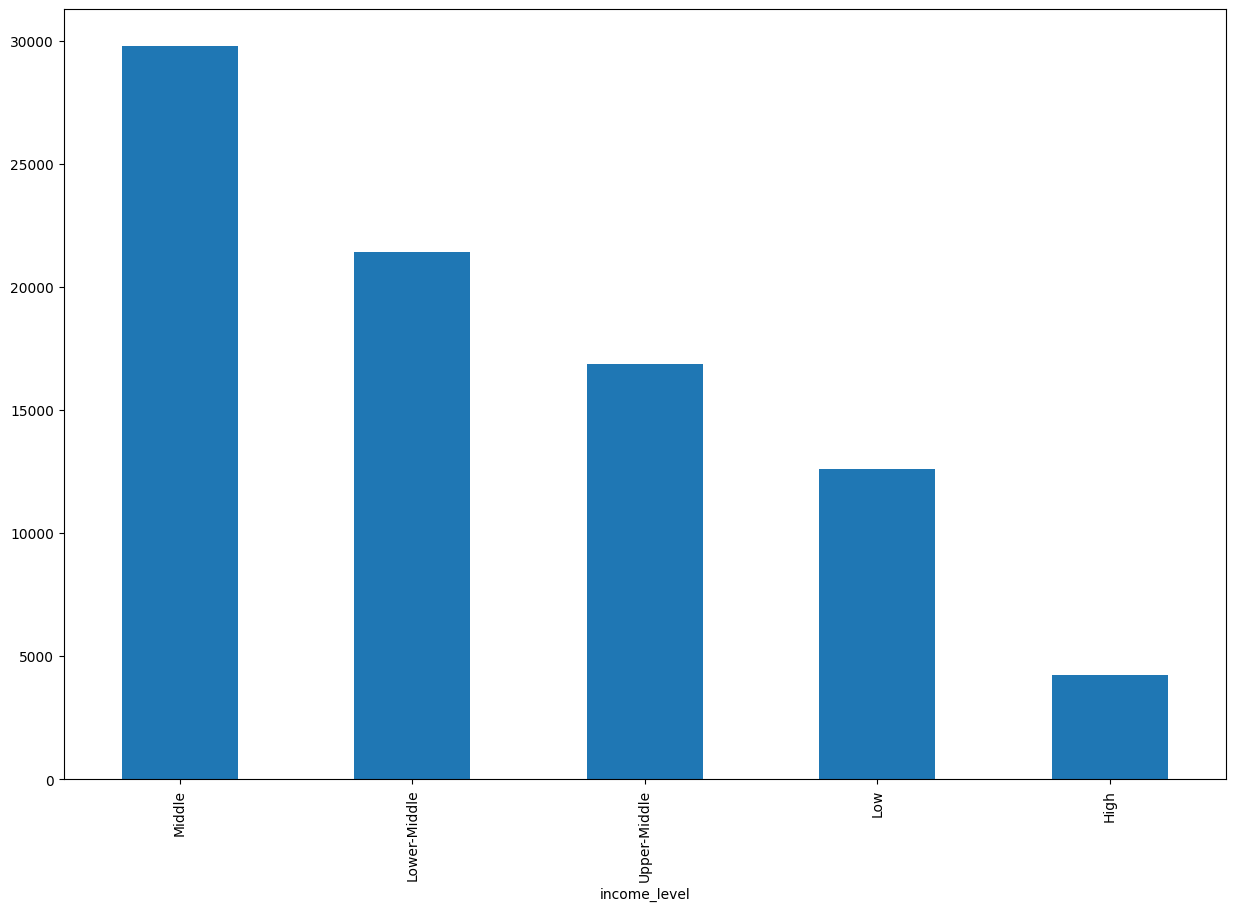

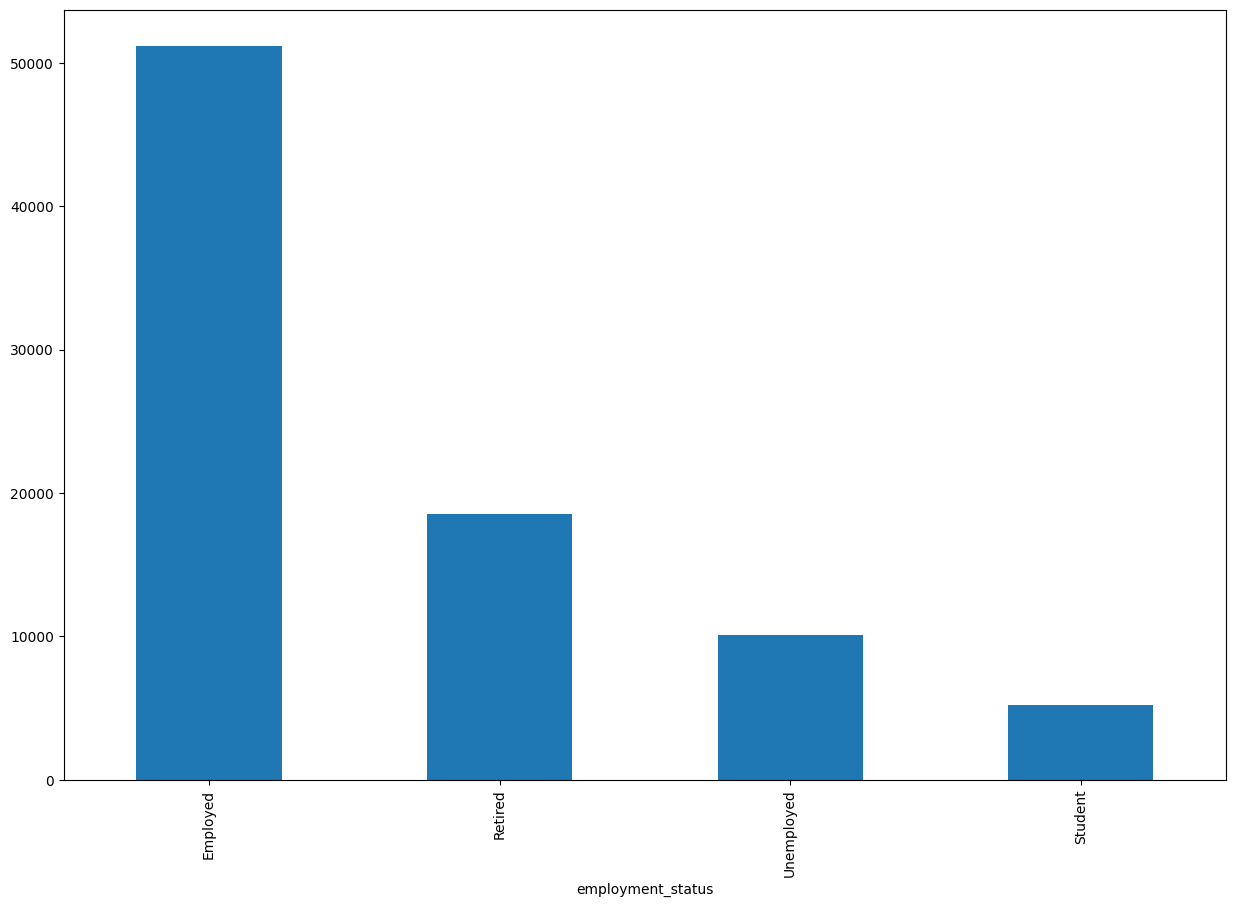

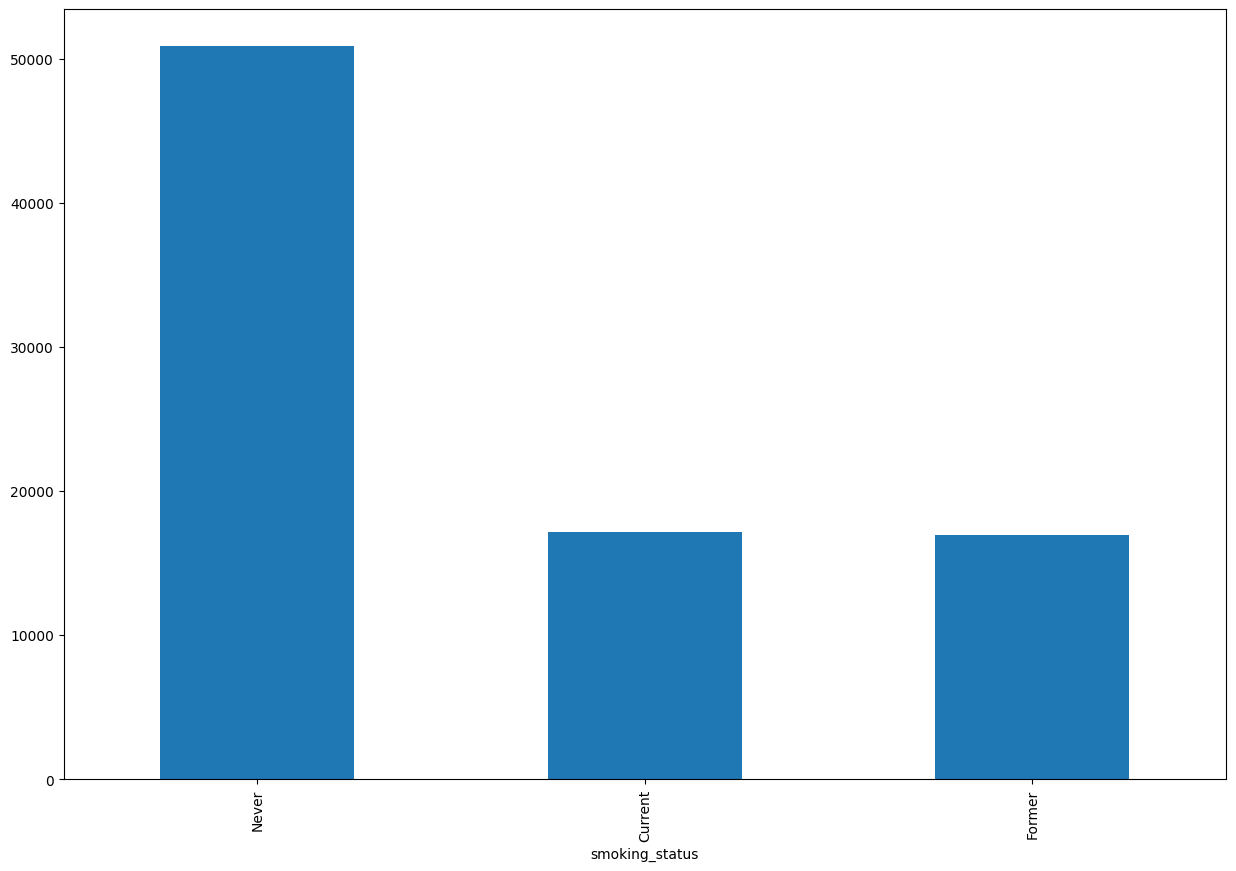

In [ ]:
for col in categorical_cols:
  plt.figure(figsize=(15,10))
  X_train_1[col].value_counts().plot(kind="bar")
  plt.show()
  print("\n")

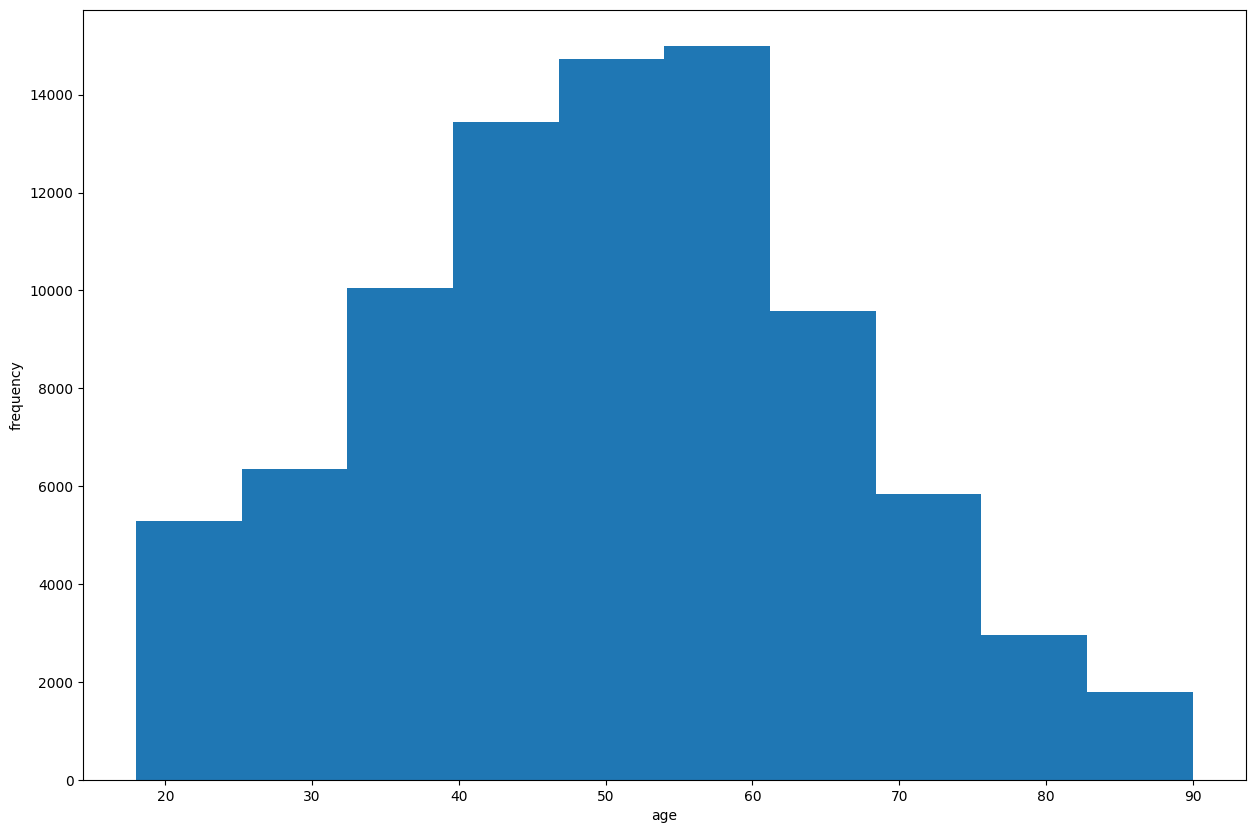

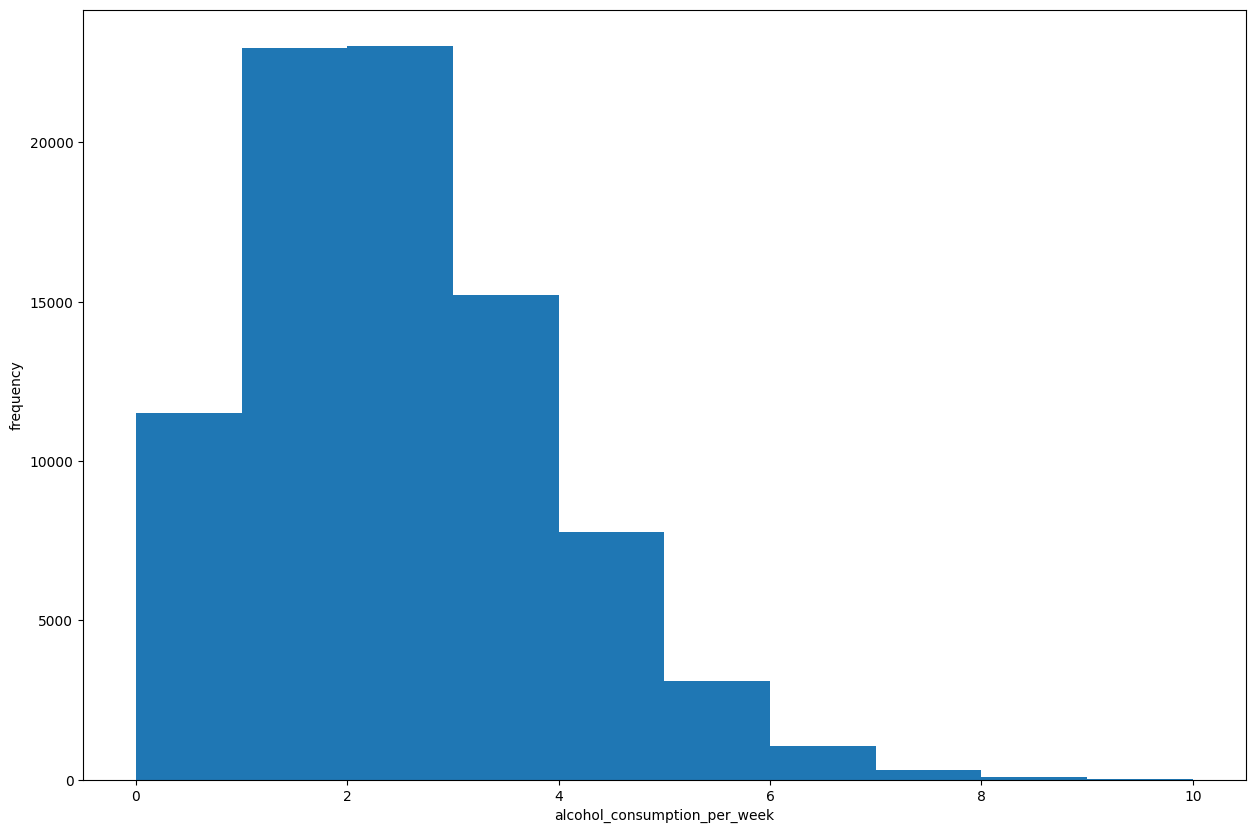

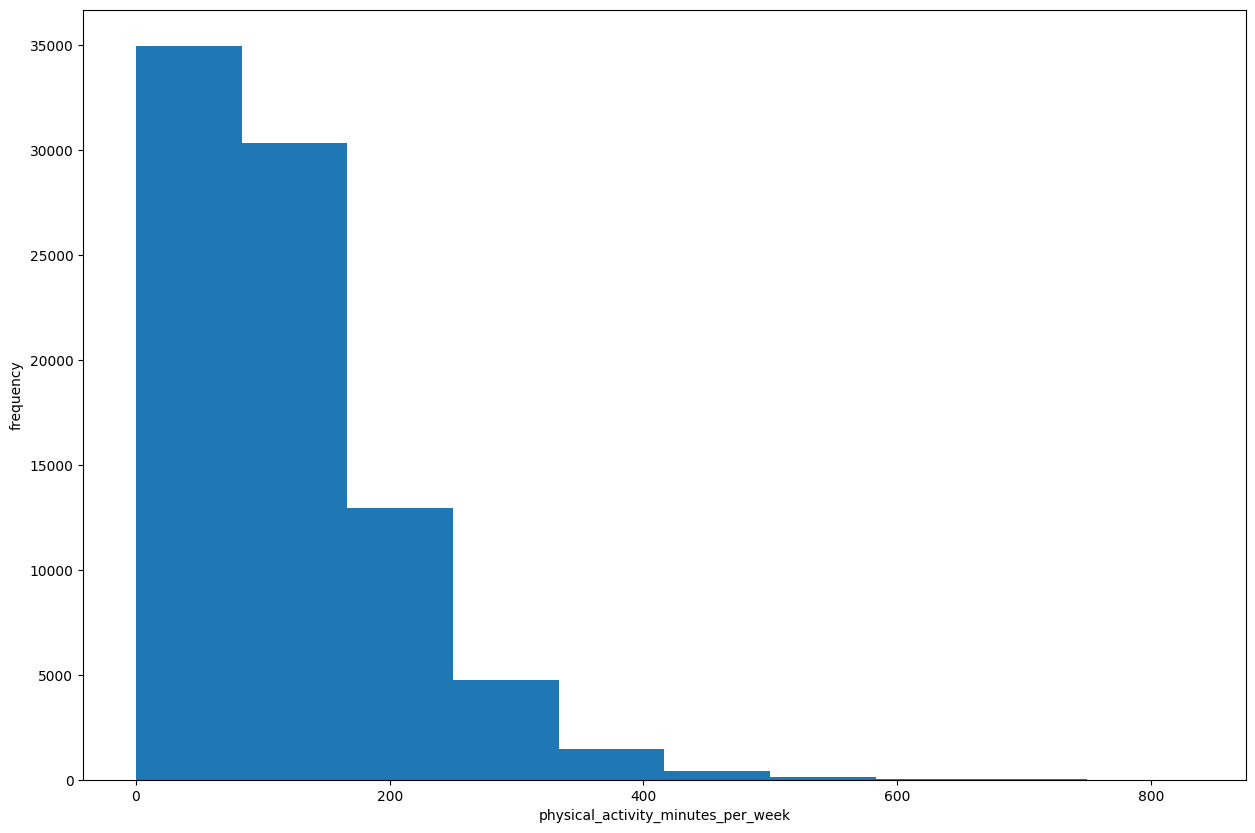

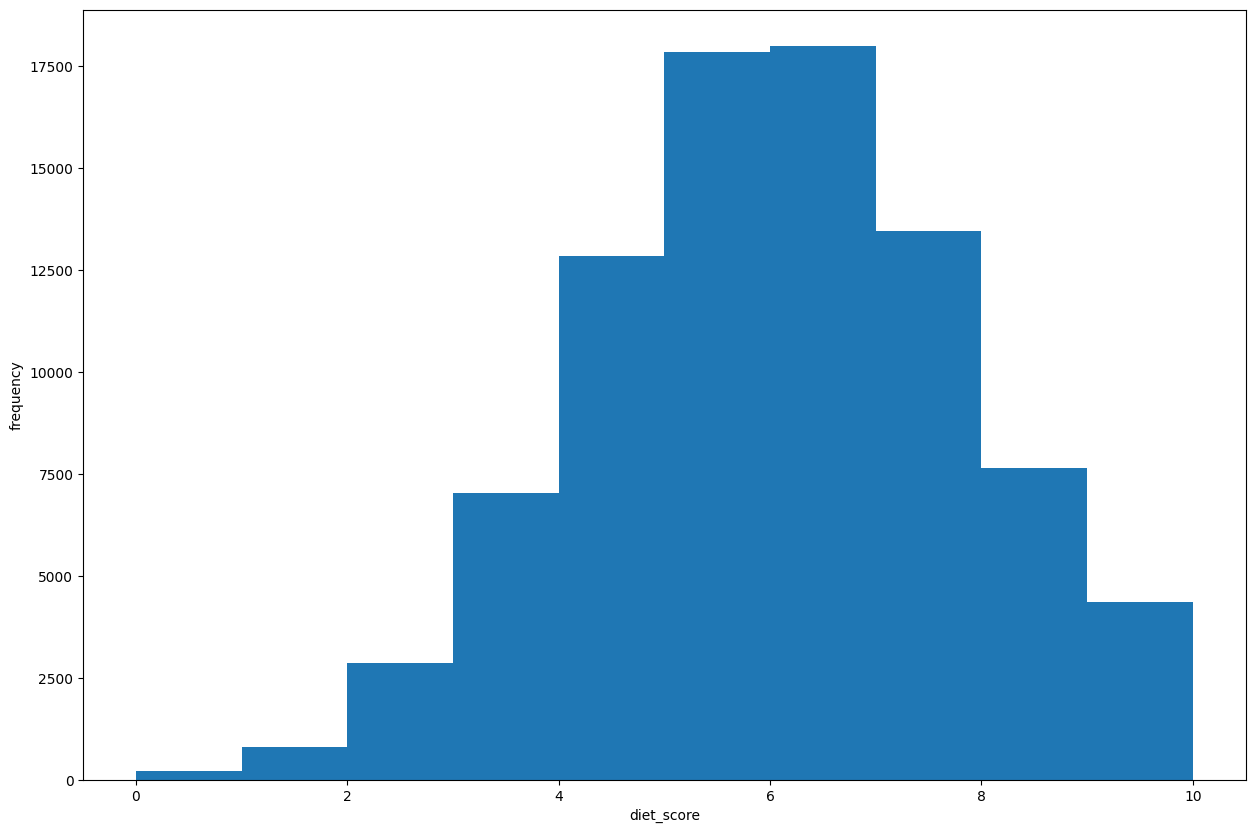

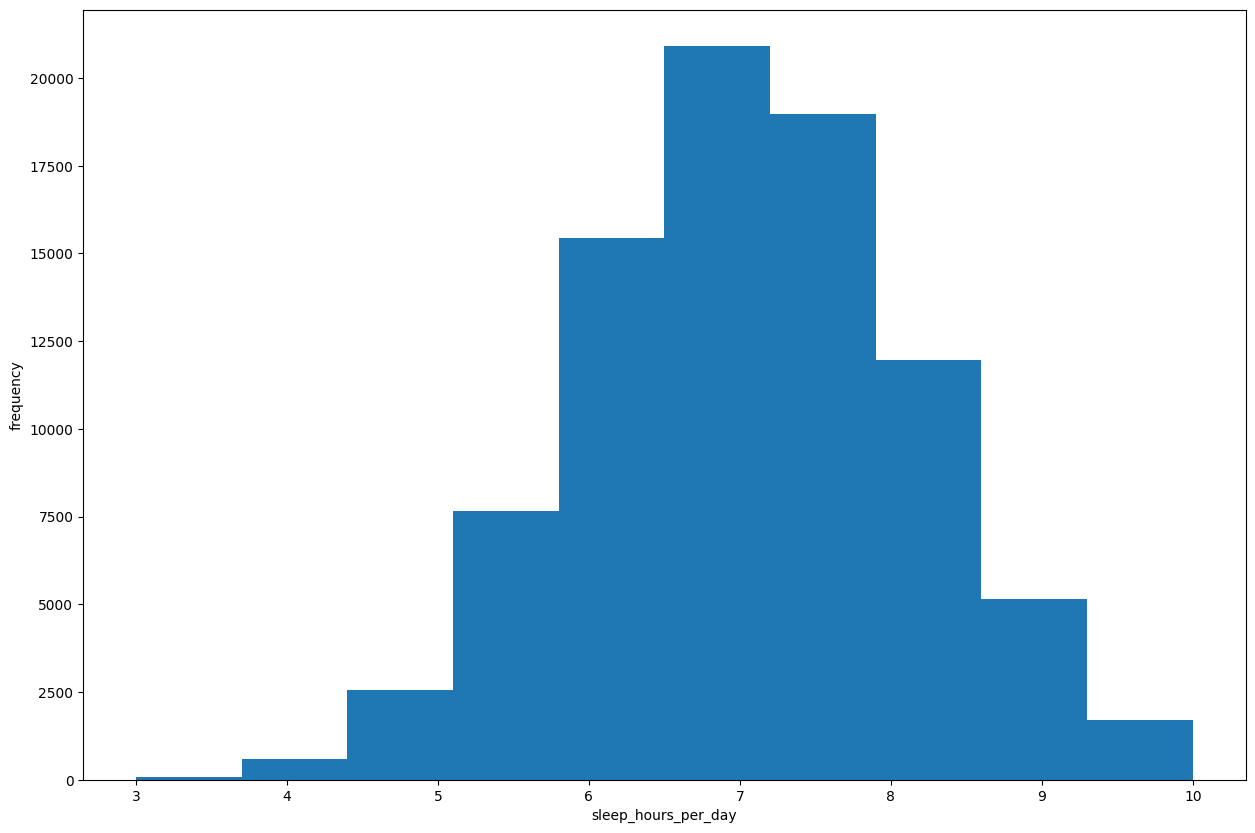

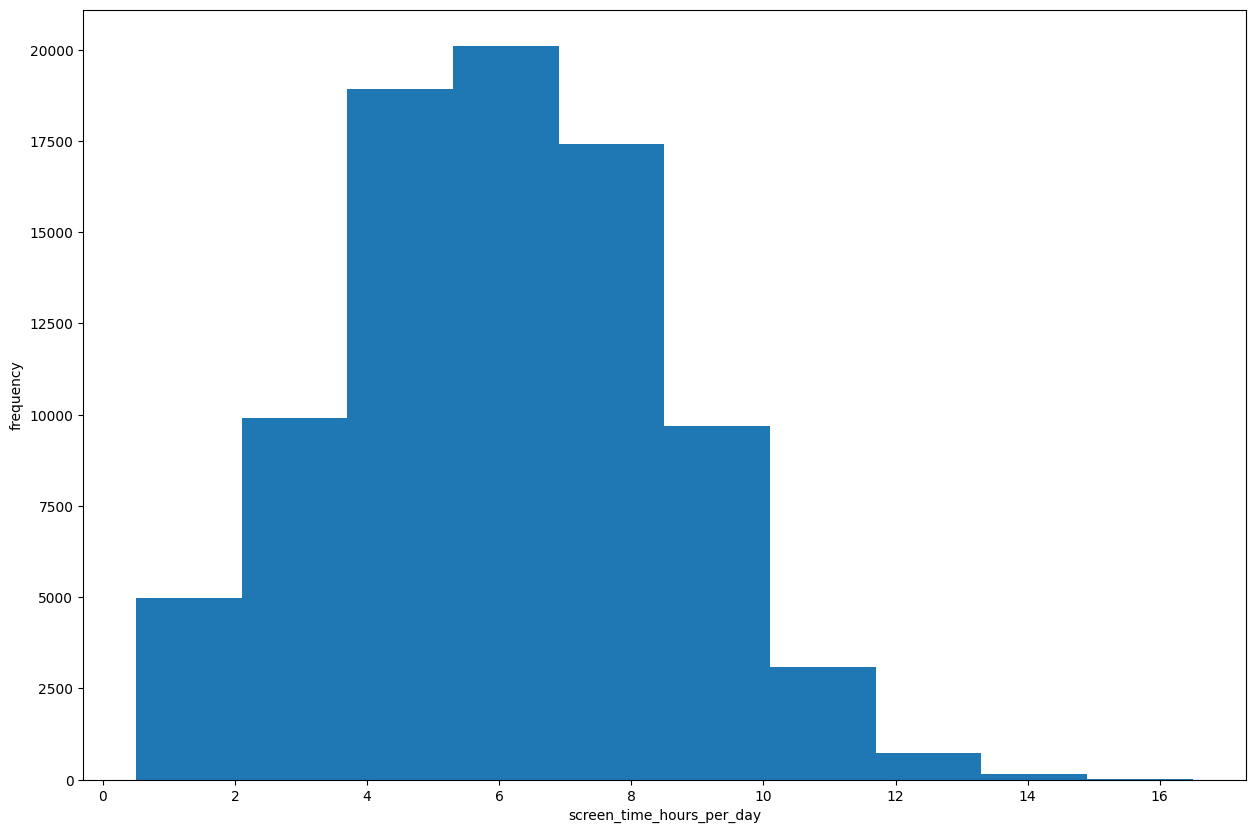

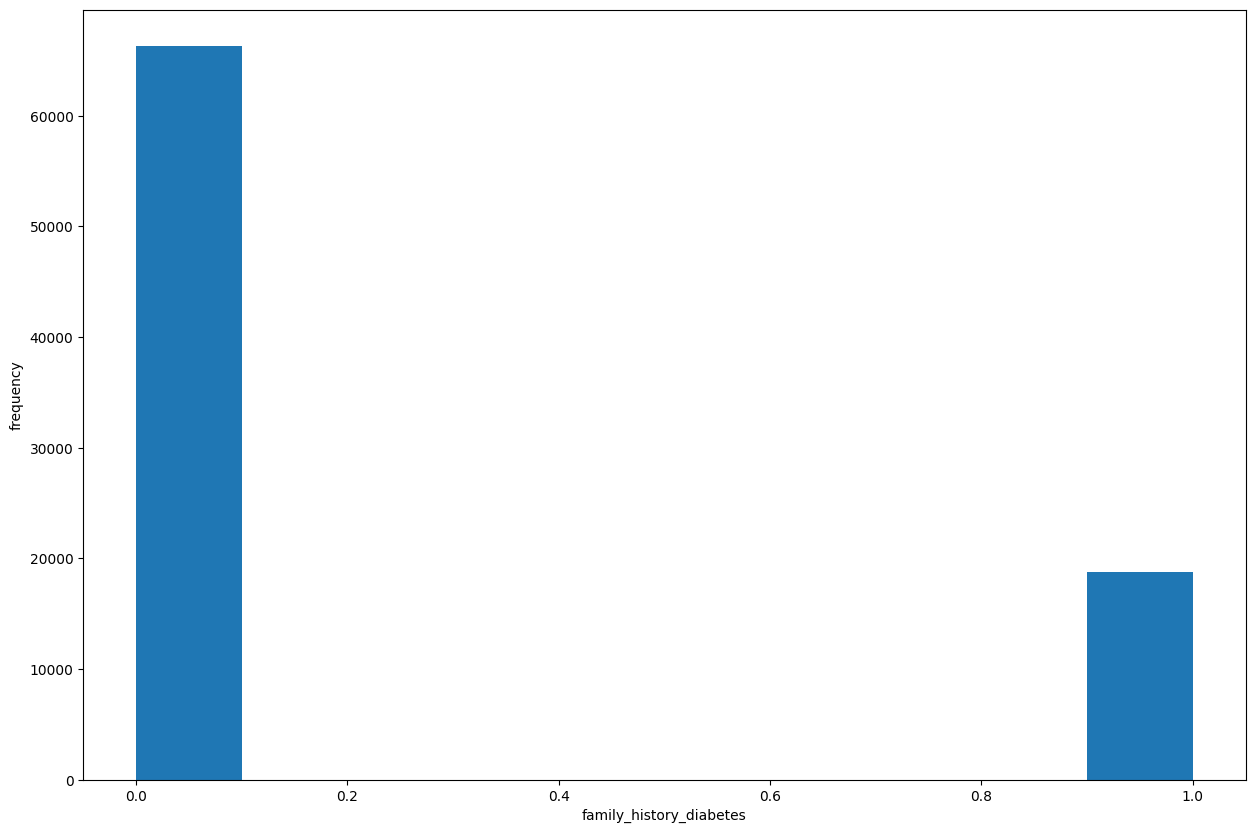

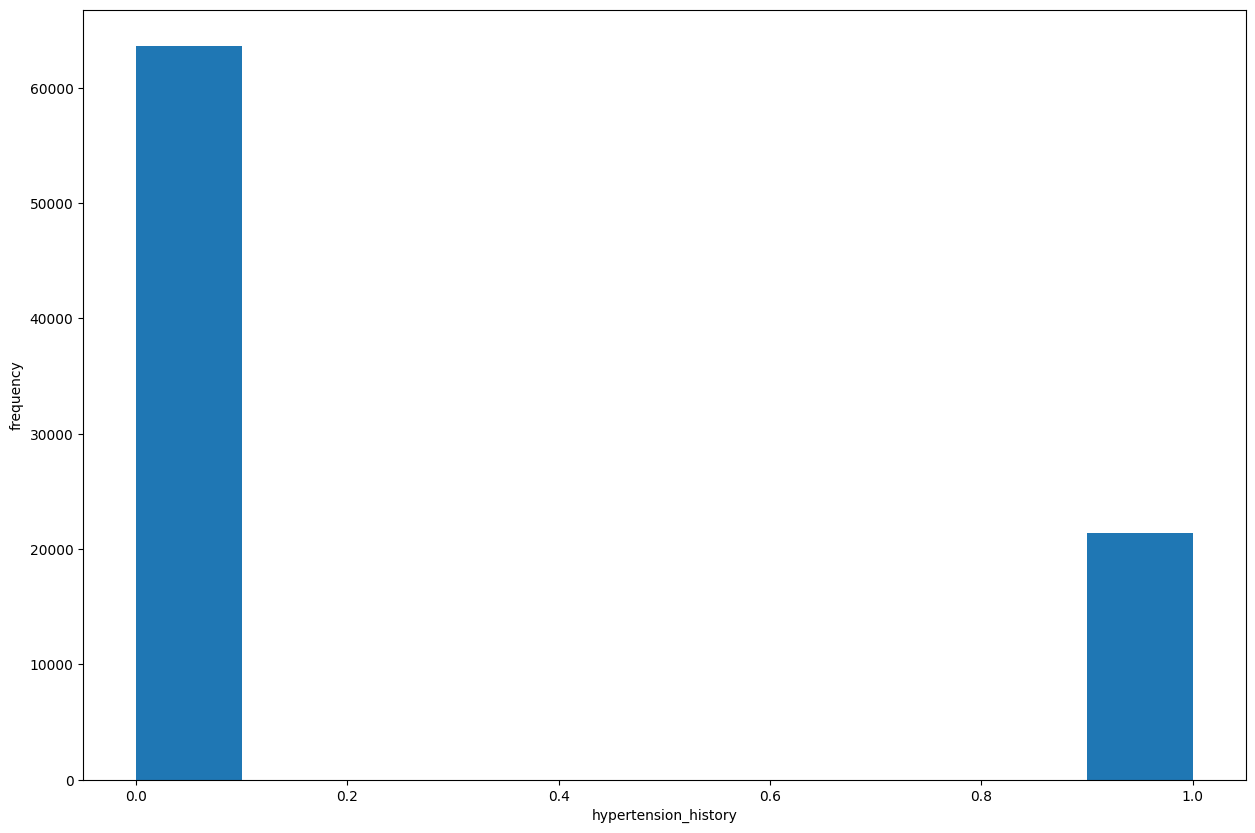

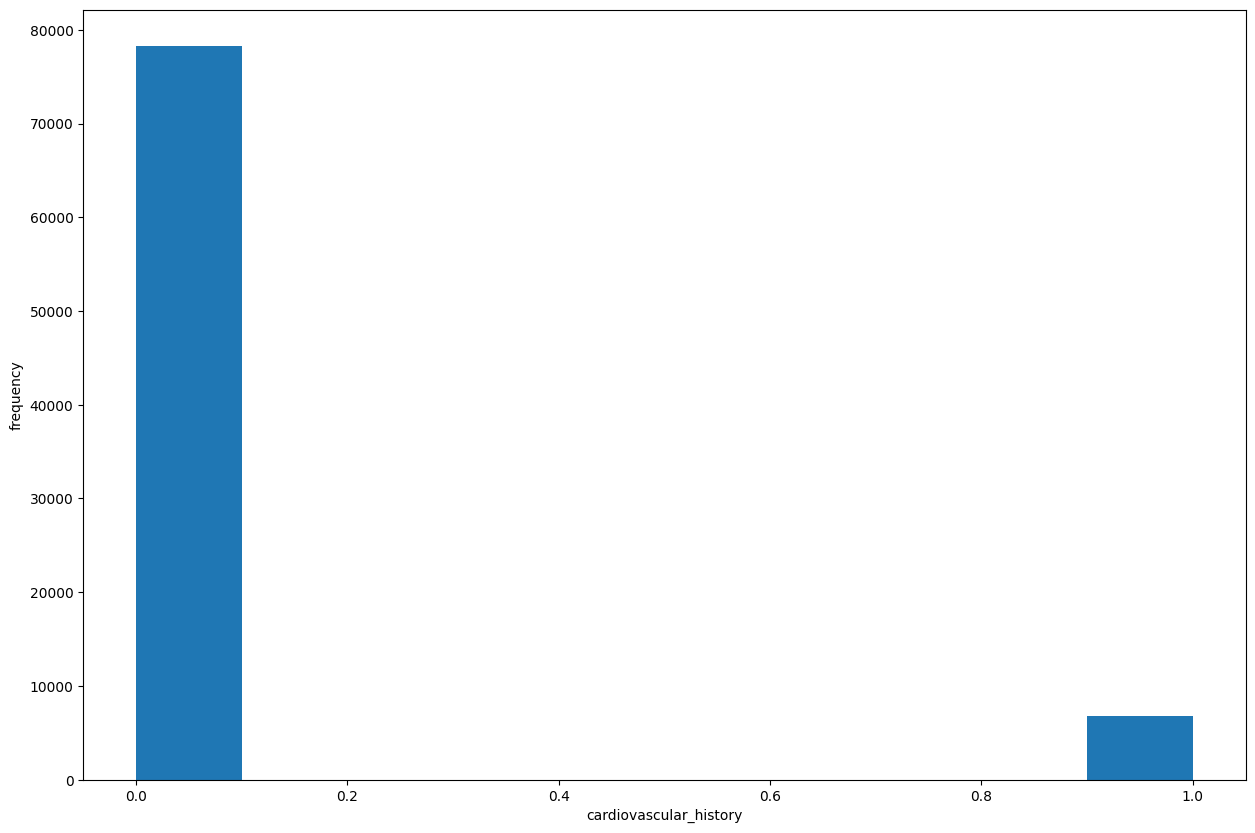

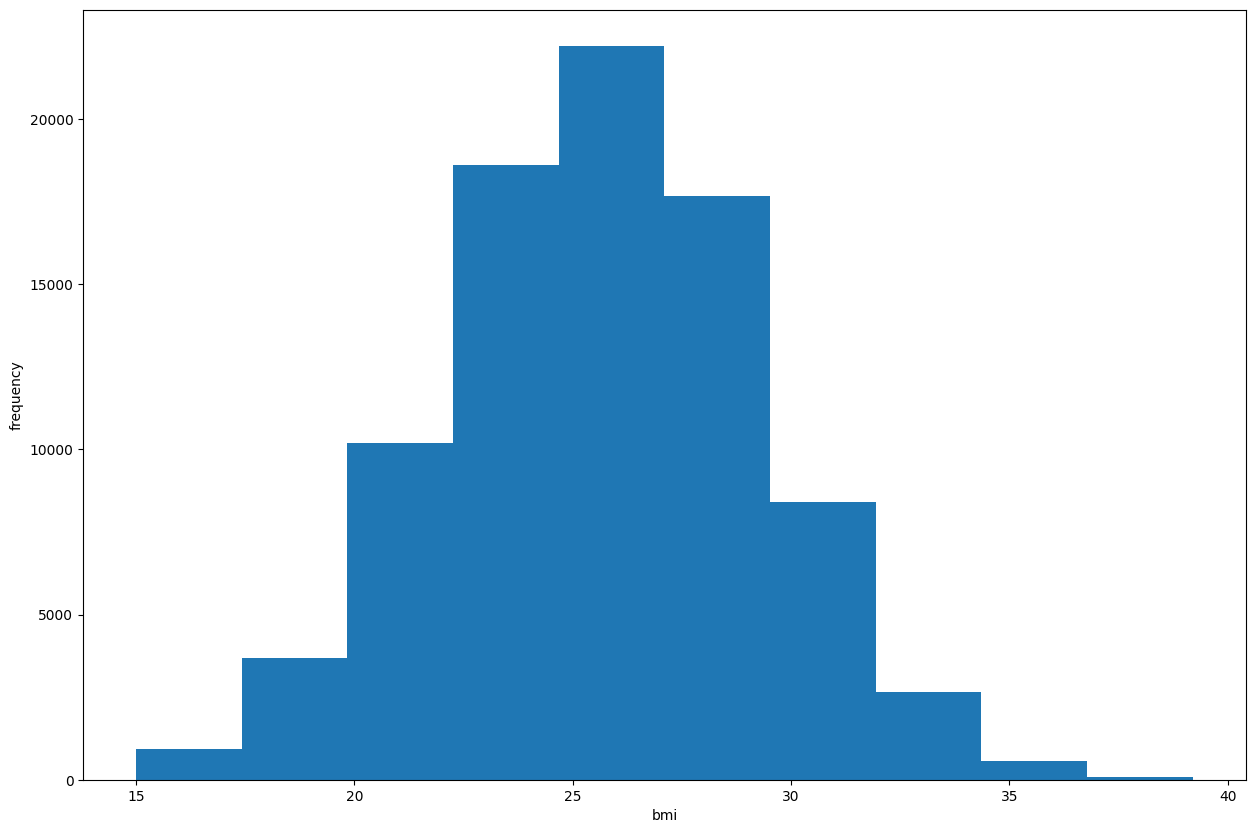

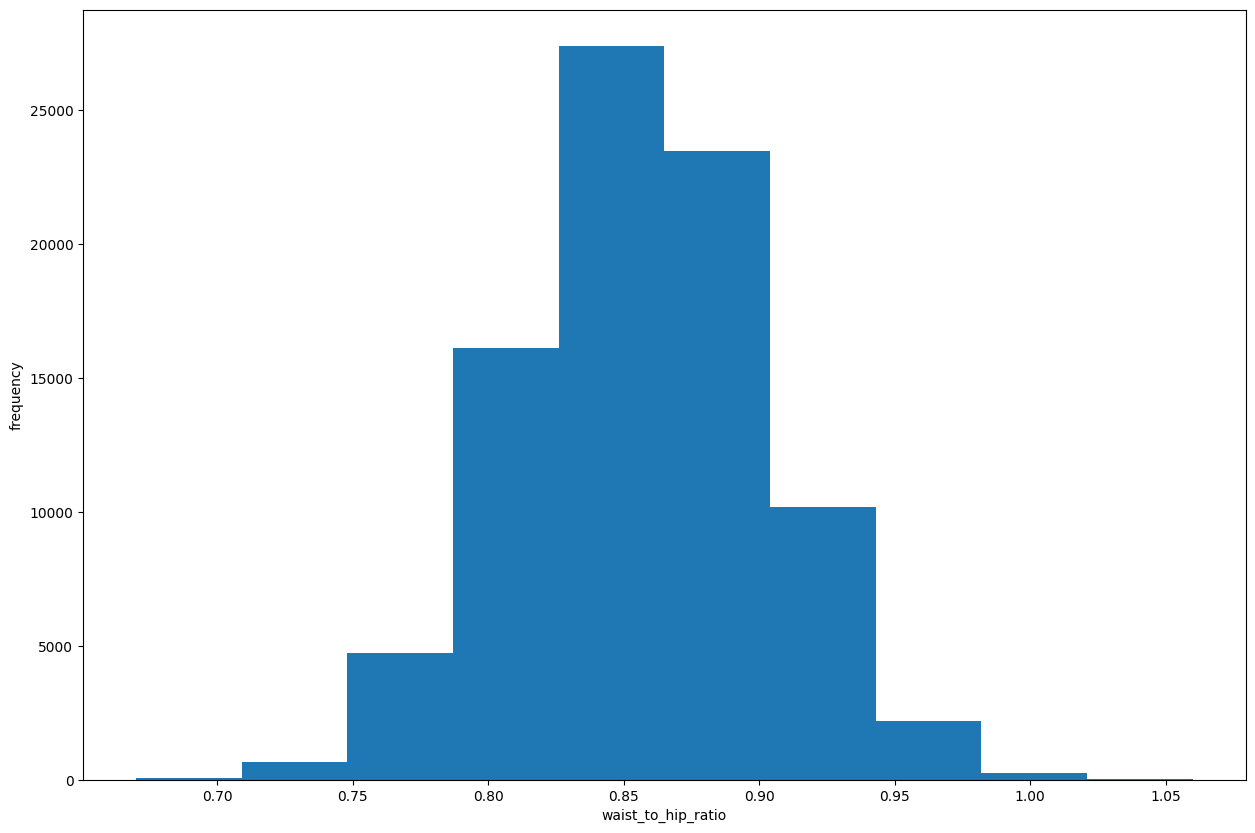

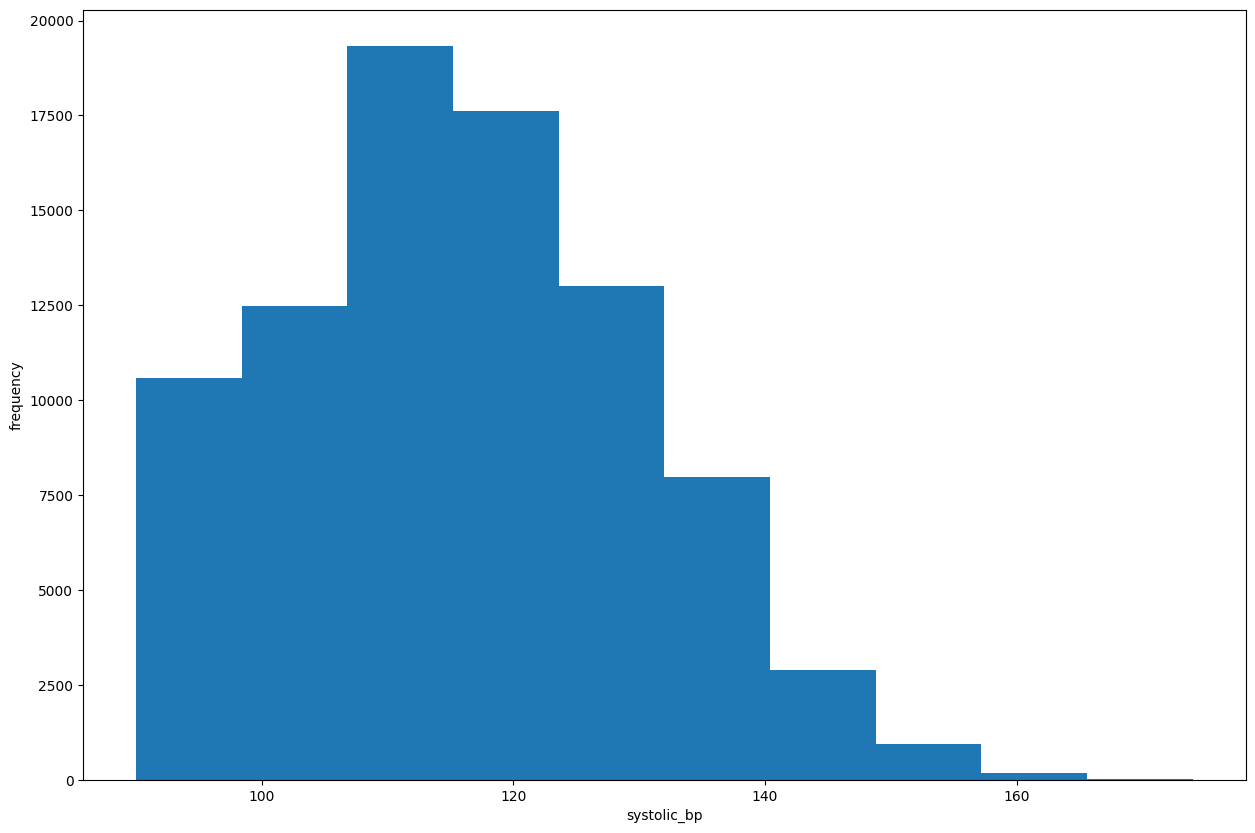

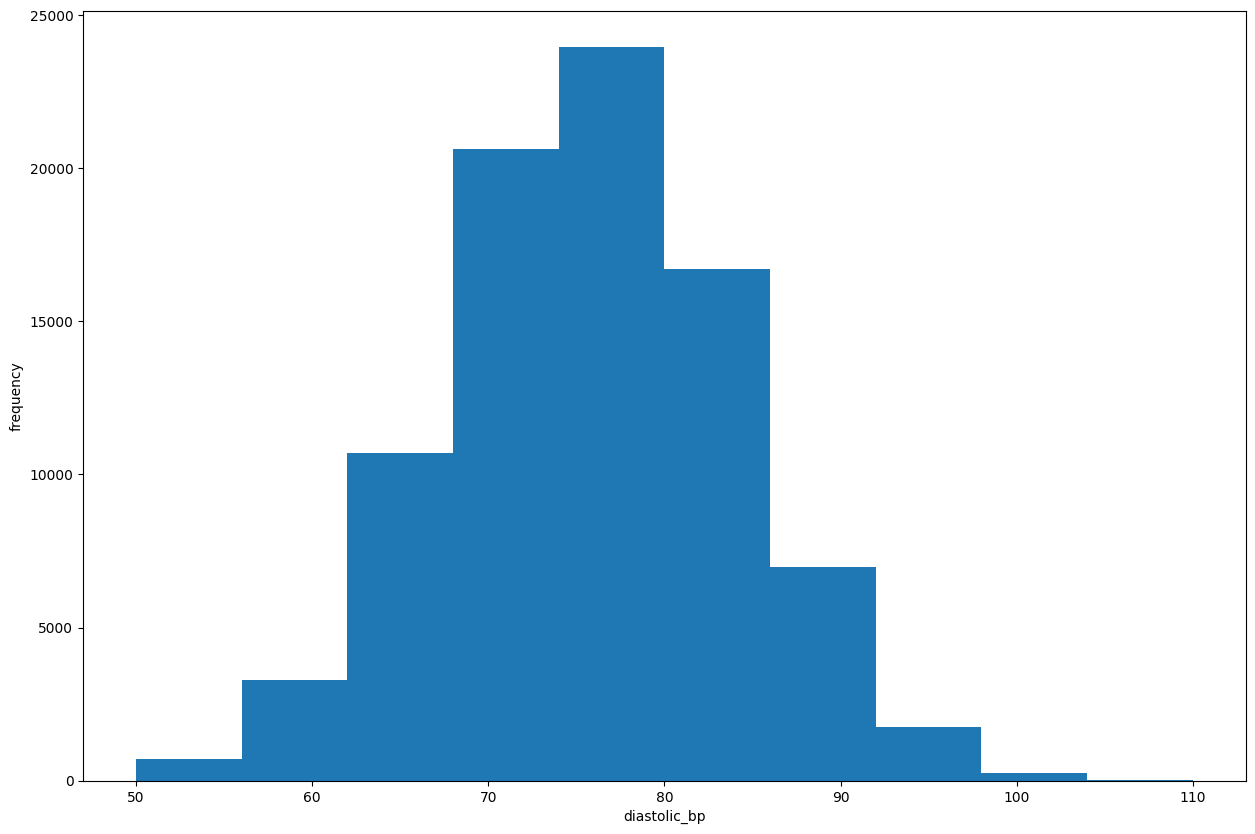

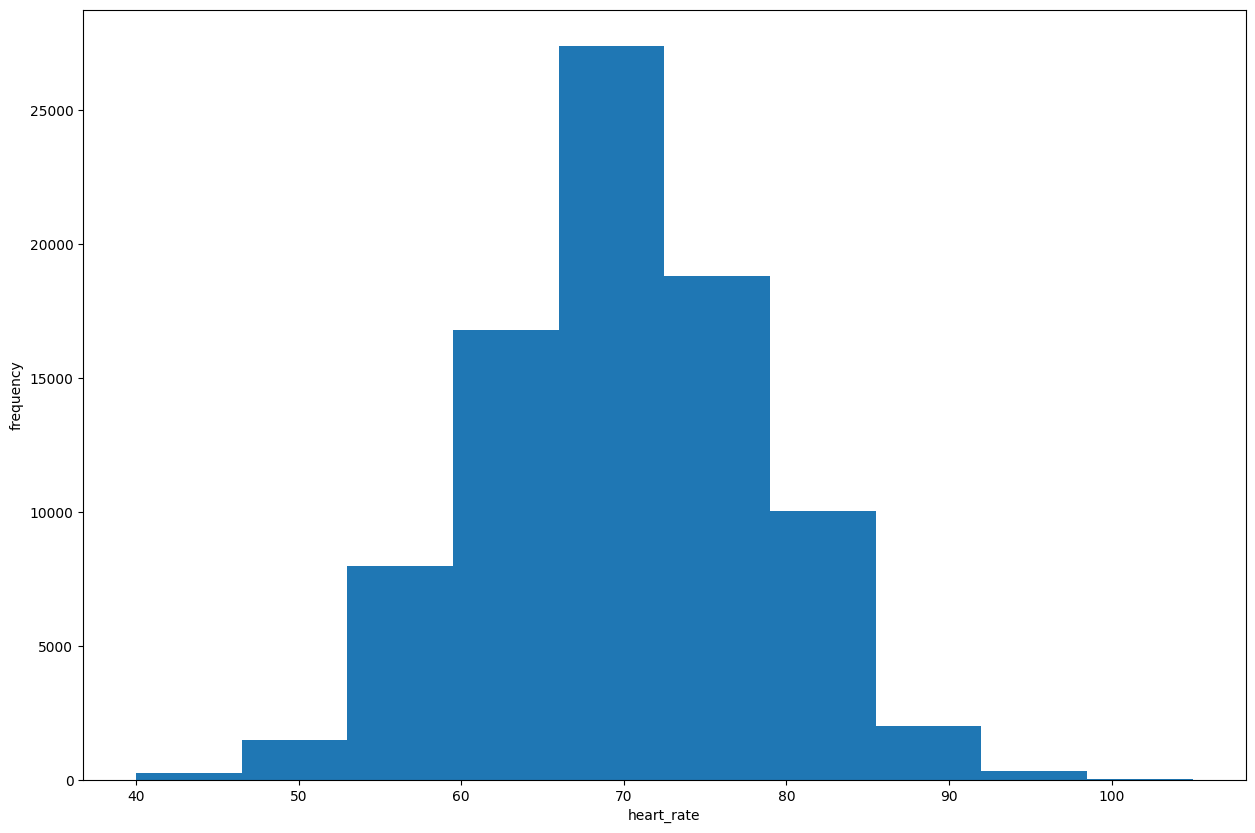

In [ ]:
for col in numerical_cols:
  plt.figure(figsize=(15,10))
  plt.hist(X_train_1[col])
  plt.xlabel(col)
  plt.ylabel("frequency")
  plt.show()
  print('\n')

In [ ]:
X_train_1.describe()

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,family_history_diabetes,hypertension_history,cardiovascular_history,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate
count,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000
mean,50.129624,2.004918,119.027271,5.994766,6.999042,6.001016,0.220329,0.251624,0.079494,25.623046,0.856165,115.803106,75.243953,69.627471
std,15.593606,1.419229,84.440803,1.782058,1.096298,2.469318,0.414471,0.433949,0.270510,3.584880,0.046808,14.270627,8.210442,8.364217
min,18.000000,0.000000,0.000000,0.000000,3.000000,0.500000,0.000000,0.000000,0.000000,15.000000,0.670000,90.000000,50.000000,40.000000
25%,39.000000,1.000000,57.000000,4.800000,6.300000,4.300000,0.000000,0.000000,0.000000,23.200000,0.820000,106.000000,70.000000,64.000000
50%,50.000000,2.000000,100.000000,6.000000,7.000000,6.000000,0.000000,0.000000,0.000000,25.600000,0.860000,116.000000,75.000000,70.000000
75%,61.000000,3.000000,161.000000,7.200000,7.700000,7.700000,0.000000,1.000000,0.000000,28.000000,0.890000,125.000000,81.000000,75.000000
max,90.000000,10.000000,833.000000,10.000000,10.000000,16.500000,1.000000,1.000000,1.000000,39.200000,1.060000,174.000000,110.000000,105.000000


## 4.4 Preprocessing Pipeline Builder

In [ ]:
def build_preprocessor(
    encode_config: list[tuple] = None,
    scale_config: list[tuple] = None,
) -> ColumnTransformer:

    """
    Build a sklearn ColumnTransformer for tabular preprocessing.

    This function ONLY constructs a preprocessing transformer.
    It does NOT fit or transform data.

    Preprocessing is defined declaratively through configuration lists and is
    applied in the following fixed order per column:

        1. Encoding
        2. Scaling

    Parameters
    ----------

    encode_config : list[tuple], optional
        List of (column, method, param) specifying encoding rules.

        method options:
        - 'onehot': param is passed to OneHotEncoder(drop=param)
            * 'first' -> drops first category (useful for linear models)
            * 'if_binary' -> drops one category from binary categories(useful for linear models)
            * None     -> keeps all categories (recommended for tree models)

        - 'ordinal': param is an ordered list of categories

        Example:
        [
            ('City', 'onehot', None),
            ('Education', 'ordinal', ['HighSchool', 'Bachelors', 'Masters'])
        ]

    scale_config : list[tuple], optional
        List of (column, strategy) specifying scaling rules.

        strategy options:
        - 'standard' → StandardScaler (z-score)
        - 'minmax'   → MinMaxScaler
        - 'robust'   → RobustScaler

        Scaling is applied only to the specified columns and is independent of
        imputation and encoding.

    Returns
    -------

    preprocessor : sklearn.compose.ColumnTransformer
        A transformer with:
        - per-column Pipelines
        - remainder="passthrough"
        - pandas output enabled
    """


    encode_config = encode_config or []
    scale_config = scale_config or []

    # Track pipeline steps per column
    col_pipelines = {}

    def get_steps(col):
        if col not in col_pipelines:
            col_pipelines[col] = []
        return col_pipelines[col]


    # -------- 1. Encoding --------
    for col, method, param in encode_config:
        steps = get_steps(col)

        if method == "onehot":
            steps.append((
                "onehot",
                OneHotEncoder(
                    handle_unknown="ignore",
                    sparse_output=False,
                    min_frequency=20,
                    drop = param,

                )
            ))

        elif method == "ordinal":
            steps.append((
                "ordinal",
                OrdinalEncoder(
                    categories=[param],
                    handle_unknown="use_encoded_value",
                    unknown_value=-1
                )
            ))

    # -------- 2. Scaling --------
    for col, strategy in scale_config:
        steps = get_steps(col)

        if strategy == "standard":
            steps.append(("scaler", StandardScaler()))
        elif strategy == "minmax":
            steps.append(("scaler", MinMaxScaler()))
        elif strategy == "robust":
            steps.append(("scaler", RobustScaler()))

    # -------- Build ColumnTransformer --------
    transformers = []
    for col, steps in col_pipelines.items():
        if steps:
            transformers.append(
                (f"pipe_{col}", Pipeline(steps), [col])
            )

    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder="passthrough",
        force_int_remainder_cols=False,
        verbose_feature_names_out=False,
        n_jobs=-1
    )

    preprocessor.set_output(transform="pandas")

    return preprocessor


## 4.5 Preprocessing Configurations

In [ ]:
encode_config_for_linear_models = [
    ('gender','onehot','first'),
    ('ethnicity','onehot','first'),
    ('education_level','ordinal',['No formal','Highschool','Graduate','Postgraduate']),
    ('income_level','ordinal',['Low','Lower-Middle','Middle','Upper-Middle','High']),
    ('employment_status','onehot','first'),
    ('smoking_status','onehot','first')
]

scale_config_for_linear_models = [
    ('age','standard'),('alcohol_consumption_per_week','standard'),
    ('physical_activity_minutes_per_week','robust'),
    ('diet_score','standard'),('sleep_hours_per_day','standard'),
    ('screen_time_hours_per_day','standard'),
    ('bmi','standard'),('systolic_bp','standard'),
    ('diastolic_bp','standard'),('heart_rate','standard'),
    ('waist_to_hip_ratio','standard')
]

encode_config_for_tree_models = [
    ('gender','onehot',None),
    ('ethnicity','onehot',None),
    ('education_level','ordinal',['No formal','Highschool','Graduate','Postgraduate']),
    ('income_level','ordinal',['Low','Lower-Middle','Middle','Upper-Middle','High']),
    ('employment_status','onehot',None),
    ('smoking_status','onehot',None)
]

## 4.6 Building Preprocessing Pipelines

In [ ]:
preprocess_linear = build_preprocessor(
    encode_config=encode_config_for_linear_models,
    scale_config=scale_config_for_linear_models
)
preprocess_tree = build_preprocessor(
    encode_config=encode_config_for_tree_models)

## 4.7 Initial Model Training and Evaluation

In [ ]:
models = {
    "ElasticNet": Pipeline([
        ("preprocess", preprocess_linear),
        ("model", ElasticNet(
            alpha=0.1,
            l1_ratio=0.5,
            max_iter=5000,
            random_state=108
        ))
    ]),

    "RandomForest": Pipeline([
        ("preprocess", preprocess_tree),
        ("model", RandomForestRegressor(
            n_estimators=300,
            max_depth=8,
            min_samples_leaf=20,
            n_jobs=-1,
            random_state=108
        ))
    ]),

    "GradientBoosting": Pipeline([
        ("preprocess", preprocess_tree),
        ("model", GradientBoostingRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=2,
            min_samples_leaf=20,
            random_state=108
        ))
    ])
}


In [ ]:
risk_bins = pd.qcut(
    y_train_1,
    q=5,              # of quintiles
    duplicates="drop"
)

X_train_1_subset, _, y_train_1_subset, _ = train_test_split(
    X_train_1,
    y_train_1,
    train_size=25000,
    random_state=108,
    stratify=risk_bins
)

In [ ]:
results = {}

for name, pipeline in models.items():
    mae = -cross_val_score(
        pipeline,
        X_train_1_subset,
        y_train_1_subset,
        cv=5,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    ).mean()

    results[name] = round(float(mae),3)

results


{'ElasticNet': 1.711, 'RandomForest': 1.415, 'GradientBoosting': 0.993}

## 4.8 Hyperparameter Optimization with Optuna

In [ ]:
def objective_gb(trial):

    gbr = GradientBoostingRegressor(
        n_estimators=trial.suggest_int("n_estimators", 200, 400, step=50),
        learning_rate=trial.suggest_float("learning_rate", 0.03, 0.08),
        max_depth=trial.suggest_int("max_depth", 1, 3),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 15, 40),
        subsample=trial.suggest_float("subsample", 0.7, 1.0),
        random_state=108
    )

    pipeline = Pipeline([
        ("preprocess", preprocess_tree),
        ("model", gbr)
    ])

    mae = -cross_val_score(
        pipeline,
        X_train_1_subset,
        y_train_1_subset,
        cv=5,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    ).mean()

    return mae


In [ ]:
gbr_study = optuna.create_study(direction="minimize",study_name = 'gbr_study')
gbr_study.optimize(objective_gb, n_trials=40)

[I 2025-12-26 10:47:53,572] A new study created in memory with name: gbr_study
[I 2025-12-26 10:48:24,892] Trial 0 finished with value: 0.9631165311589915 and parameters: {'n_estimators': 300, 'learning_rate': 0.06444499859504109, 'max_depth': 2, 'min_samples_leaf': 21, 'subsample': 0.7109382137879882}. Best is trial 0 with value: 0.9631165311589915.
[I 2025-12-26 10:48:51,244] Trial 1 finished with value: 1.3347309055232026 and parameters: {'n_estimators': 400, 'learning_rate': 0.037014238110809144, 'max_depth': 1, 'min_samples_leaf': 34, 'subsample': 0.8188545888378869}. Best is trial 0 with value: 0.9631165311589915.
[I 2025-12-26 10:49:39,900] Trial 2 finished with value: 0.9710915989170139 and parameters: {'n_estimators': 250, 'learning_rate': 0.048003998296888895, 'max_depth': 3, 'min_samples_leaf': 22, 'subsample': 0.9453951832893401}. Best is trial 0 with value: 0.9631165311589915.
[I 2025-12-26 10:50:06,579] Trial 3 finished with value: 1.2574229257050205 and parameters: {'n_e

##4.9 Optuna Study Results

In [ ]:
gbr_study.trials_dataframe().sort_values(by="value", ascending=True)

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_min_samples_leaf,params_n_estimators,params_subsample,state
8,8,0.950353,2025-12-26 10:52:13.120828,2025-12-26 10:52:58.582058,0 days 00:00:45.461230,0.079349,2,37,350,0.959755,COMPLETE
31,31,0.950562,2025-12-26 11:11:05.048093,2025-12-26 11:12:07.003996,0 days 00:01:01.955903,0.051081,3,18,400,0.733323,COMPLETE
22,22,0.950678,2025-12-26 11:03:14.564401,2025-12-26 11:04:12.078704,0 days 00:00:57.514303,0.060605,3,15,350,0.786482,COMPLETE
33,33,0.950832,2025-12-26 11:13:13.923033,2025-12-26 11:14:18.314702,0 days 00:01:04.391669,0.055128,3,19,400,0.771266,COMPLETE
38,38,0.951452,2025-12-26 11:17:21.489694,2025-12-26 11:18:26.123970,0 days 00:01:04.634276,0.053259,3,35,400,0.774287,COMPLETE
32,32,0.951497,2025-12-26 11:12:07.005343,2025-12-26 11:13:13.920050,0 days 00:01:06.914707,0.055108,3,23,400,0.808240,COMPLETE
24,24,0.952913,2025-12-26 11:05:02.524616,2025-12-26 11:06:02.036310,0 days 00:00:59.511694,0.059861,3,24,350,0.822245,COMPLETE
30,30,0.952918,2025-12-26 11:10:02.798425,2025-12-26 11:11:05.047123,0 days 00:01:02.248698,0.050805,3,18,400,0.722188,COMPLETE
12,12,0.953467,2025-12-26 10:54:34.853096,2025-12-26 10:55:32.720093,0 days 00:00:57.866997,0.060014,3,15,350,0.777965,COMPLETE
21,21,0.953486,2025-12-26 11:02:18.512487,2025-12-26 11:03:14.563414,0 days 00:00:56.050927,0.062860,3,15,350,0.758040,COMPLETE


In [ ]:
gbr_study.best_params

{'n_estimators': 350,
 'learning_rate': 0.07934873712919313,
 'max_depth': 2,
 'min_samples_leaf': 37,
 'subsample': 0.9597545928779427}

In [ ]:
gbr_study.best_value

0.9503532019481856

##4.10  Final Gradient Boosting Regressor Pipeline

In [ ]:
gbr_pipeline  =  Pipeline([
        ("preprocess", preprocess_tree),
        ("model", GradientBoostingRegressor(
          n_estimators = gbr_study.best_params['n_estimators'],
          learning_rate = gbr_study.best_params['learning_rate'],
          max_depth = gbr_study.best_params['max_depth'],
          min_samples_leaf= gbr_study.best_params['min_samples_leaf'],
          subsample= gbr_study.best_params['subsample'],
          random_state = 108
        ))
    ])

In [ ]:
gbr_pipeline.fit(X_train_1,y_train_1)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('pipe_gender',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 min_frequency=20,
                                                                                 sparse_output=False))]),
                                                  ['gender']),
                                                 ('pipe_ethnicity',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 min_frequ...
                                                 ('pipe_smoking_status',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 min_frequency=20,
                                                                                 sparse_output=False))]),
                                                  ['smoking_status'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.07934873712919313,
                                           max_depth=2, min_samples_leaf=37,
                                           n_estimators=350, random_state=108,
                                           subsample=0.9597545928779427))])

##4.11 Model Evaluation on Test Data

In [ ]:
y_pred_1 = gbr_pipeline.predict(X_test_1)

In [ ]:
mae = mean_absolute_error(y_test_1, y_pred_1)

print(f"Test MAE: {mae:.4f}")

Test MAE: 0.9482


## 4.12 Final Model Training and Saving

In [ ]:
gbr_pipeline.fit(X_1,y_1)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('pipe_gender',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 min_frequency=20,
                                                                                 sparse_output=False))]),
                                                  ['gender']),
                                                 ('pipe_ethnicity',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 min_frequ...
                                                 ('pipe_smoking_status',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 min_frequency=20,
                                                                                 sparse_output=False))]),
                                                  ['smoking_status'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.07934873712919313,
                                           max_depth=2, min_samples_leaf=37,
                                           n_estimators=350, random_state=108,
                                           subsample=0.9597545928779427))])

In [ ]:
joblib.dump(gbr_pipeline, "diabetes_risk_model_gbr.pkl")


['diabetes_risk_model_gbr.pkl']

#5. Diabetes Prediction

## 5.1 Out-of-Fold Risk Score Prediction

In [ ]:
def generate_oof_predictions(
    pipeline,
    X: pd.DataFrame,
    y: pd.Series,
    n_splits: int = 5,
    random_state: int = 108,
):
    """
    Generate out-of-fold (OOF) predictions for a regression model.

    Parameters
    ----------
    pipeline : sklearn Pipeline
        Pipeline containing preprocessing + trained estimator (unfitted).
    X : pd.DataFrame
        Feature matrix (raw, unprocessed).
    y : pd.Series
        Target variable (diabetes_risk_score).
    n_splits : int, default=5
        Number of CV folds.
    random_state : int, default=108
        Random seed for reproducibility.

    Returns
    -------
    oof_preds : pd.Series
        Out-of-fold predictions aligned with X.index.
    """

    kf = KFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    oof_preds = np.zeros(len(X))

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]

        # Clone pipeline to avoid contamination between folds
        model = clone(pipeline)

        model.fit(X_train_fold, y_train_fold)
        oof_preds[val_idx] = model.predict(X_val_fold)

    return pd.Series(oof_preds, index=X.index, name="risk_score_pred")


In [ ]:
risk_oof = generate_oof_predictions(
    pipeline=gbr_pipeline,
    X=X_1,
    y=y_1,
)

##5.2 Feature Engineering for Diabetes Prediction

In [ ]:
features_for_prediction_2 = ['age', 'gender',
                           'ethnicity', 'education_level',
                           'income_level', 'employment_status',
                           'smoking_status', 'alcohol_consumption_per_week',
                           'physical_activity_minutes_per_week',
                           'diet_score', 'sleep_hours_per_day',
                           'screen_time_hours_per_day',
                           'family_history_diabetes',
                           'hypertension_history',
                           'cardiovascular_history', 'bmi',
                           'waist_to_hip_ratio', 'systolic_bp',
                           'diastolic_bp', 'heart_rate',
                           'cholesterol_total', 'hdl_cholesterol',
                           'ldl_cholesterol', 'triglycerides',
                           'glucose_fasting', 'glucose_postprandial',
                           'insulin_level', 'hba1c']
feature_to_predict_2 = 'diagnosed_diabetes'

In [ ]:
X_2 = df[features_for_prediction_2]
y_2 = df[feature_to_predict_2]
X_2.loc[:,'diabetes_risk_score_pred'] = risk_oof
X_2.head()

/tmp/ipython-input-586996139.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2.loc[:,'diabetes_risk_score_pred'] = risk_oof


,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score_pred
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,68,239,41,160,145,136,236,6.36,8.18,28.419705
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,67,116,55,50,30,93,150,2.00,5.63,23.630279
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,74,213,66,99,36,118,195,5.07,7.51,45.959319
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,68,171,50,79,140,139,253,5.28,9.03,37.476317
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,67,210,52,125,160,137,184,12.74,7.20,22.928353


##5.3 Data Splitting and Initial Exploration

In [ ]:
X_train_2,X_test_2,y_train_2,y_test_2 = train_test_split(
    X_2,
    y_2,
    test_size=0.15,
    random_state=108
)

In [ ]:
new_numerical_cols = ['cholesterol_total', 'hdl_cholesterol',
                           'ldl_cholesterol', 'triglycerides',
                           'glucose_fasting', 'glucose_postprandial',
                           'insulin_level', 'hba1c','diabetes_risk_score_pred']

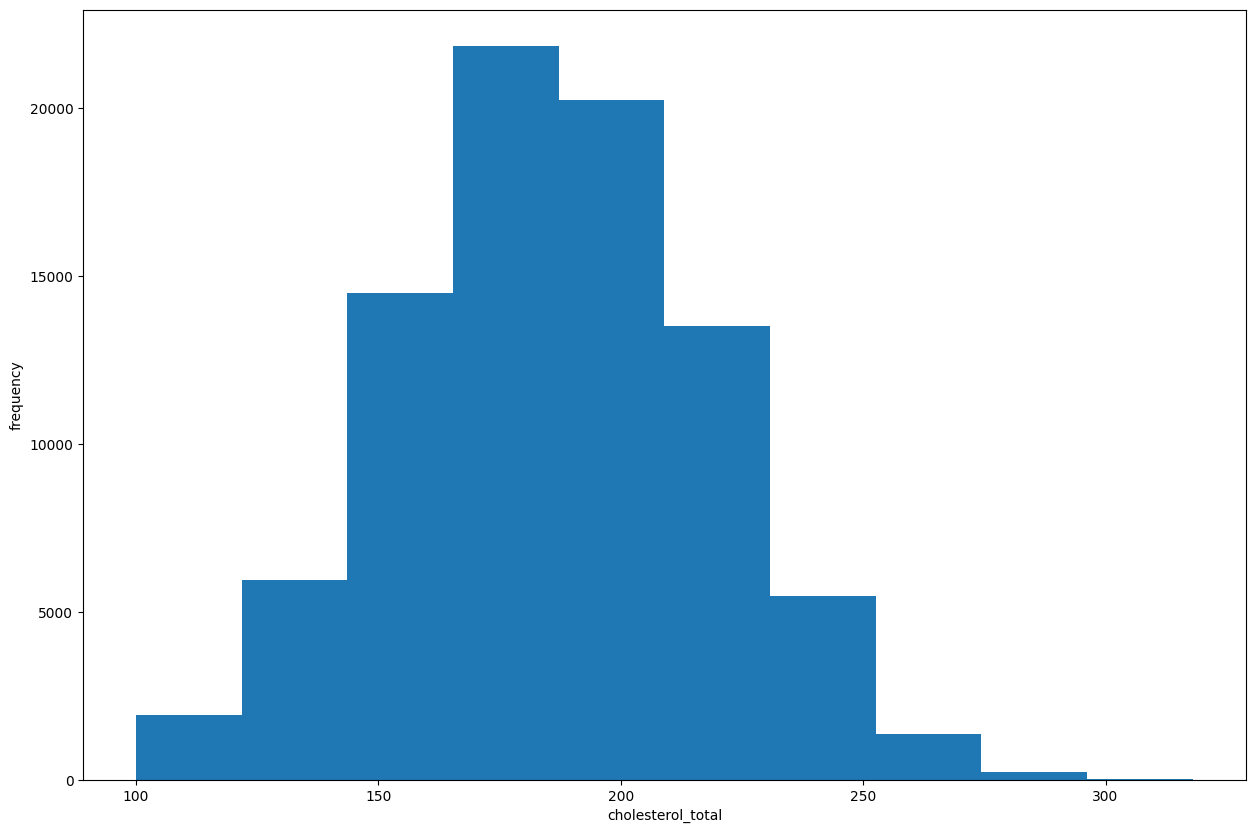

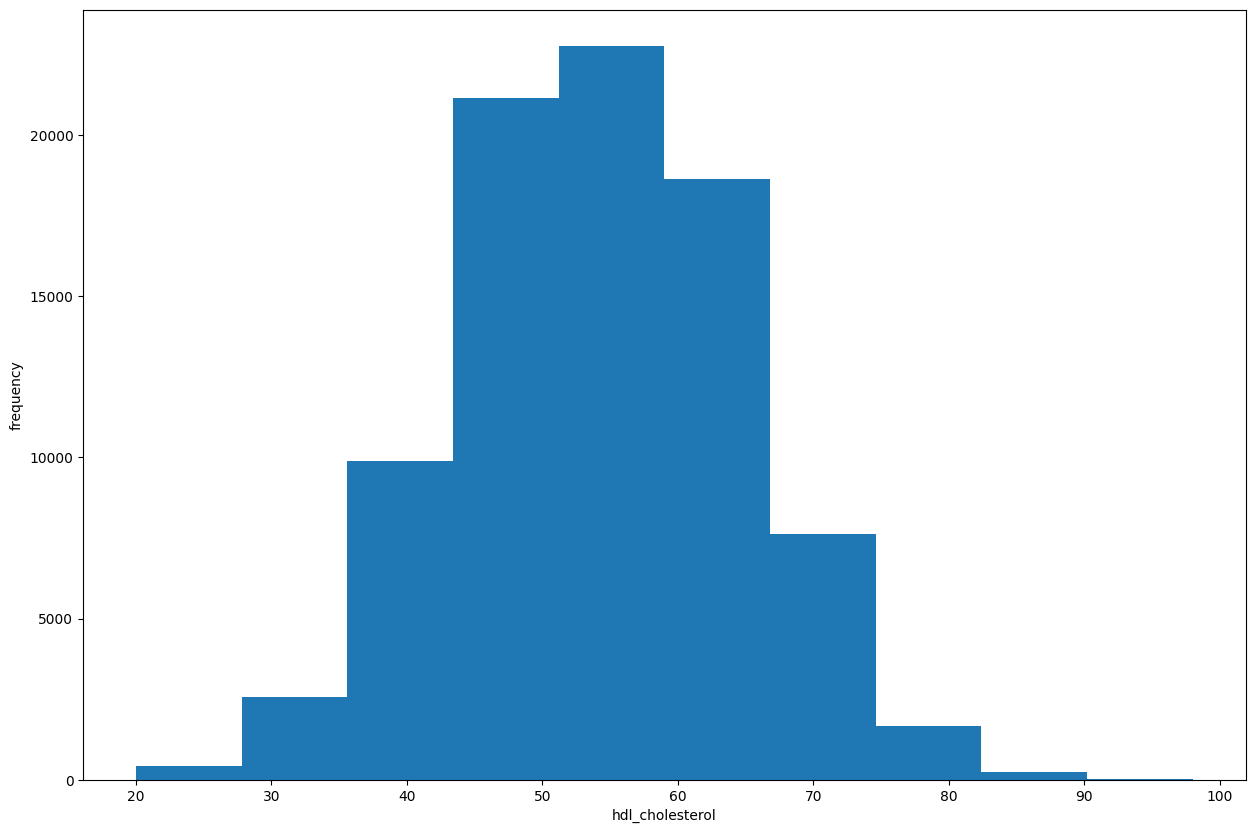

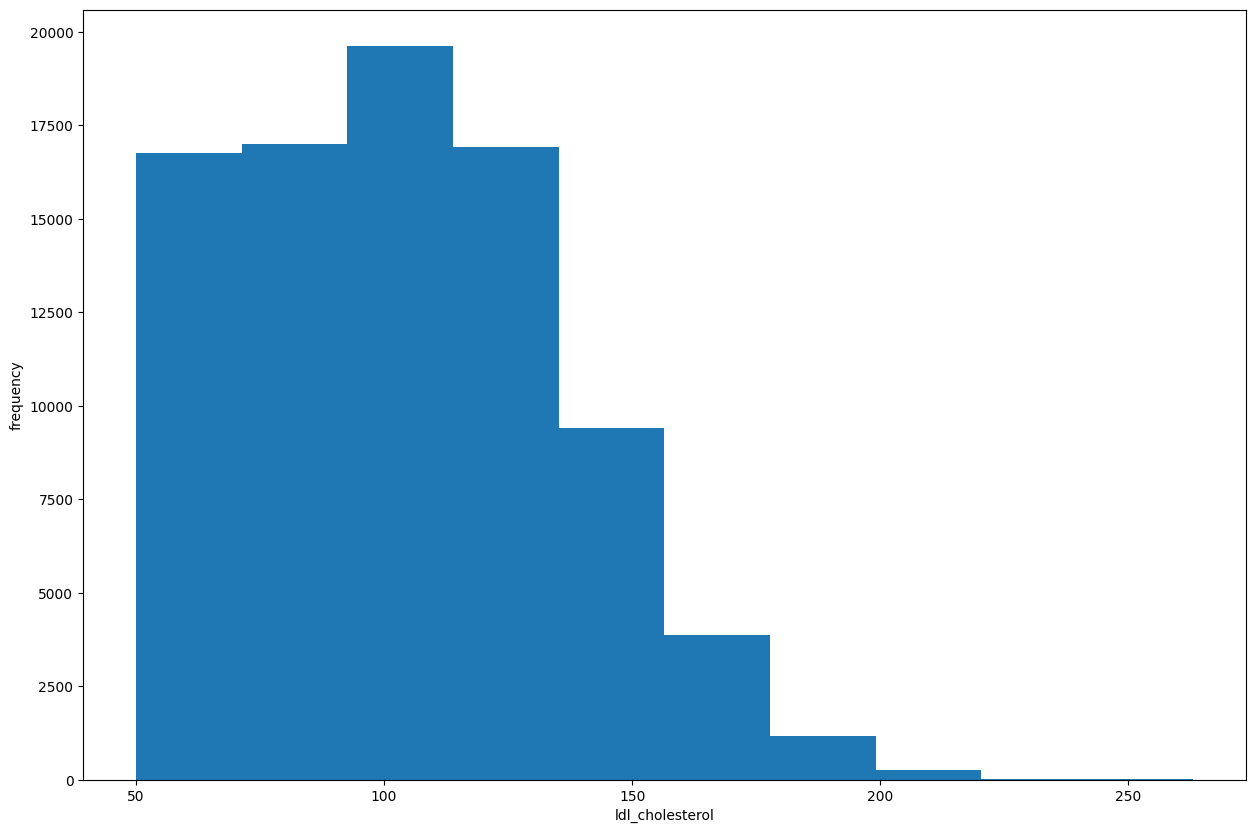

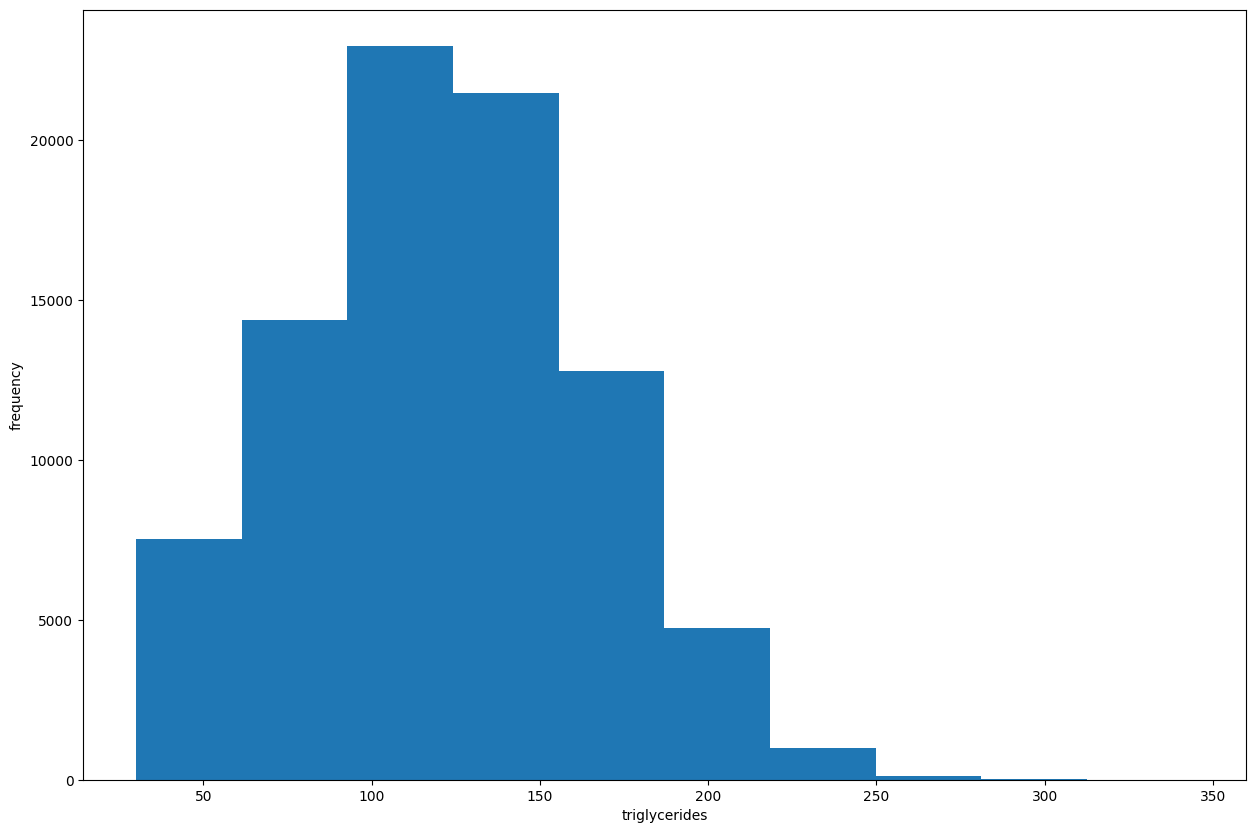

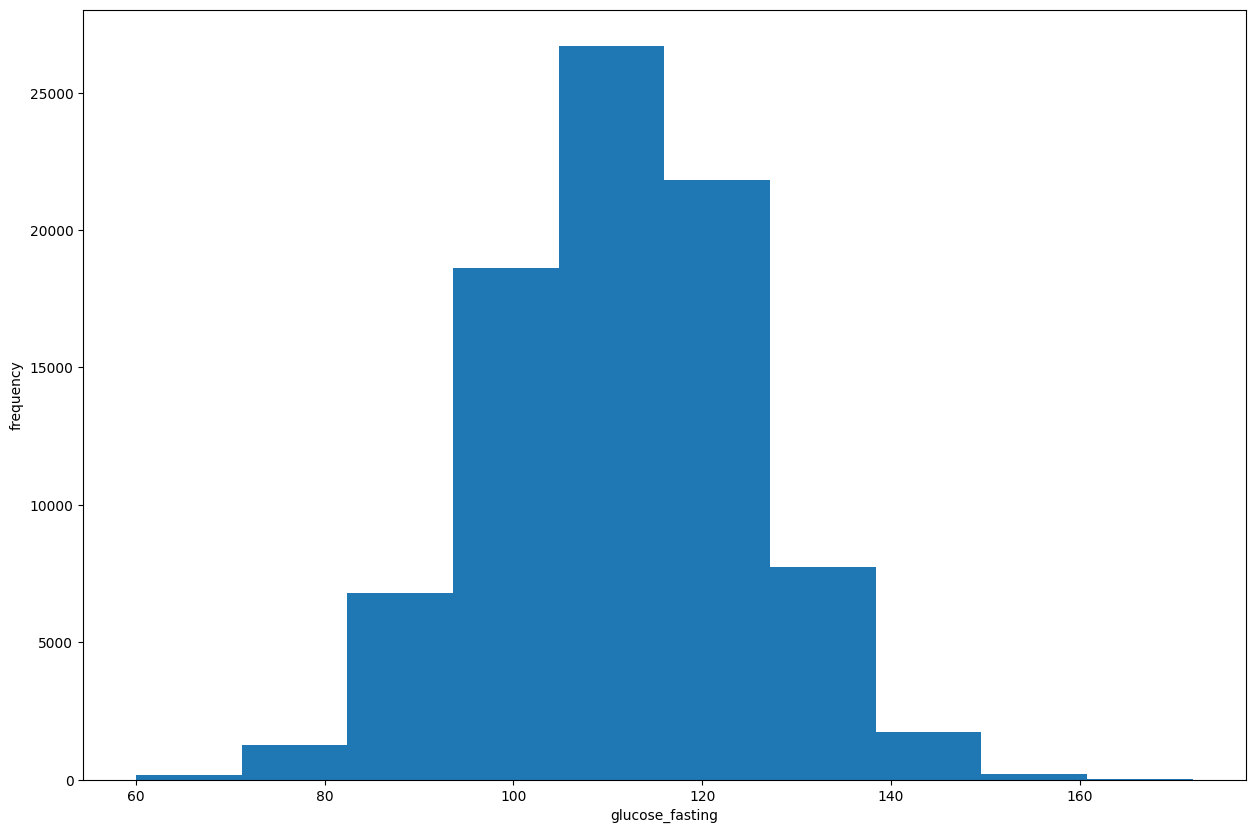

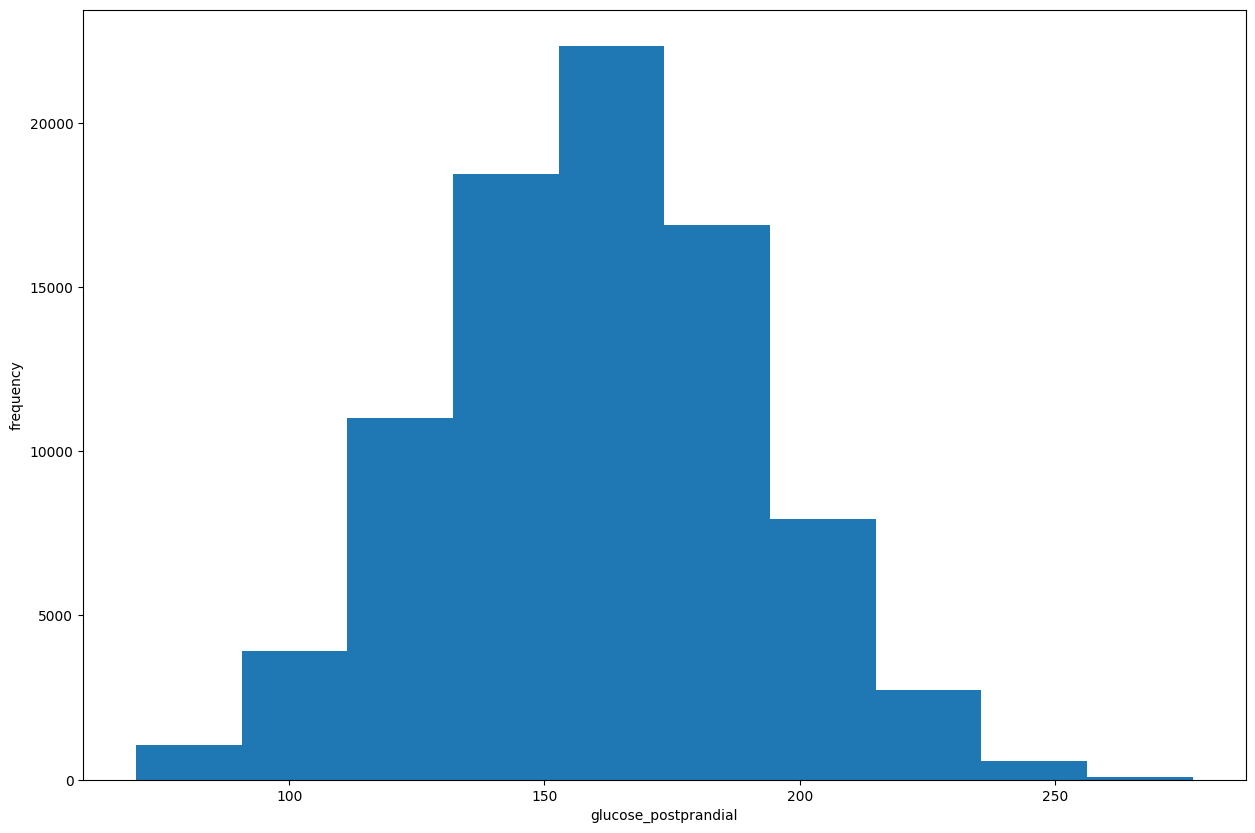

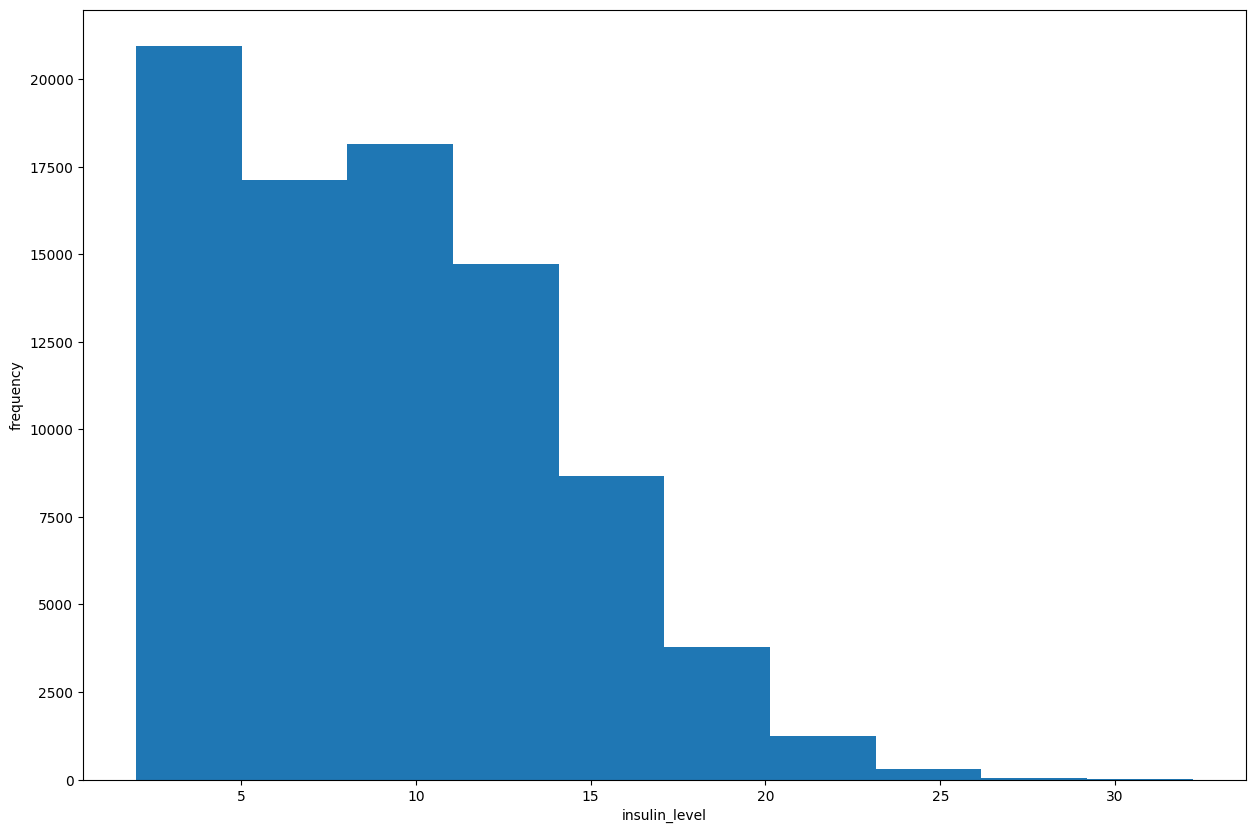

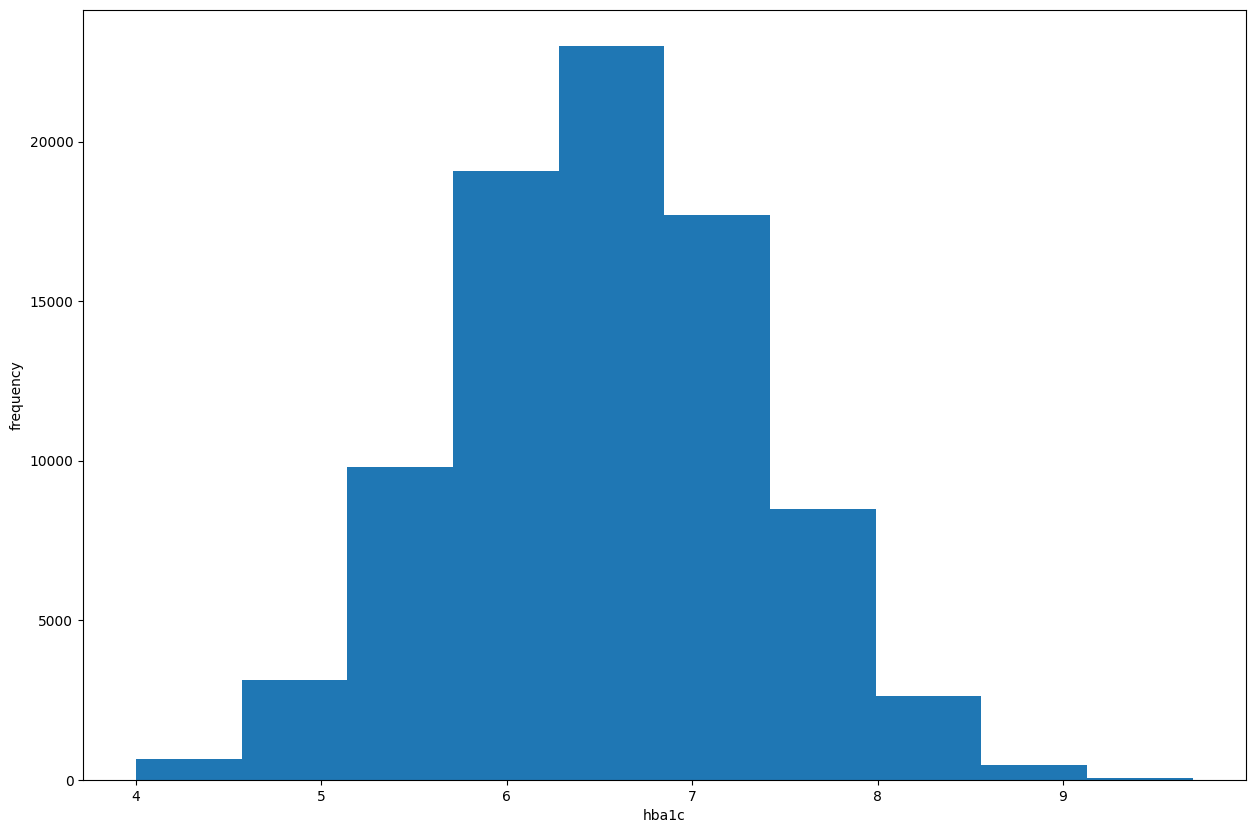

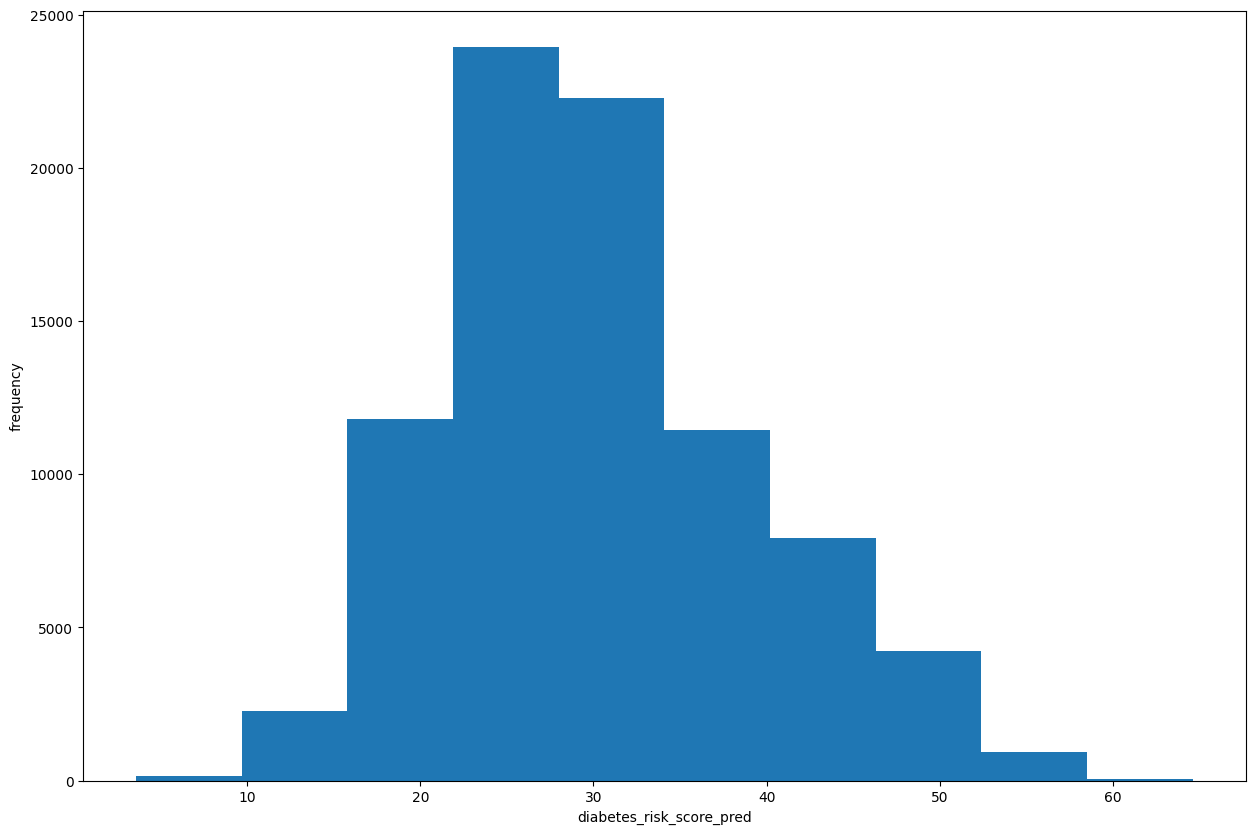

In [ ]:
for col in new_numerical_cols:
  plt.figure(figsize=(15,10))
  plt.hist(X_train_2[col])
  plt.xlabel(col)
  plt.ylabel("frequency")
  plt.show()

##5.4 Preprocessing Configuration

In [ ]:
scale_config_for_linear_models_2 = [
    ('age','standard'),('alcohol_consumption_per_week','standard'),
    ('physical_activity_minutes_per_week','robust'),
    ('diet_score','standard'),('sleep_hours_per_day','standard'),
    ('screen_time_hours_per_day','standard'),
    ('bmi','standard'),('systolic_bp','standard'),
    ('diastolic_bp','standard'),('heart_rate','standard'),
    ('waist_to_hip_ratio','standard'),
    ('diabetes_risk_score_pred','standard')
]


In [ ]:
preprocess_linear_2 = build_preprocessor(
    encode_config=encode_config_for_linear_models,
    scale_config=scale_config_for_linear_models_2)


##5.5 Initial Model Training and Evaluation

In [ ]:
X_train_2_subset, _, y_train_2_subset, _ = train_test_split(
    X_train_2, y_train_2,
    train_size=25000,
    stratify=y_train_2,
    random_state=108
)


In [ ]:
neg = (y_train_2_subset == 0).sum()
pos = (y_train_2_subset == 1).sum()
class_ratio = neg / pos

models = {
    "LogisticRegression": Pipeline([
        ("preprocess", preprocess_linear_2),
        ("model", LogisticRegression(
            max_iter=3000,
            class_weight="balanced",
            n_jobs=-1,
            random_state=108
        ))
    ]),

    "RandomForest": Pipeline([
        ("preprocess", preprocess_tree),
        ("model", RandomForestClassifier(
            n_estimators=300,
            max_depth=6,
            min_samples_leaf=10,
            class_weight="balanced",
            n_jobs=-1,
            random_state=108
        ))
    ]),

    "GradientBoosting": Pipeline([
        ("preprocess", preprocess_tree),
        ("model", GradientBoostingClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=2,
            min_samples_leaf=20,
            random_state=108
        ))
    ]),

    "XGBoost": Pipeline([
        ("preprocess", preprocess_tree),
        ("model", XGBClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=2,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=class_ratio,
            eval_metric="aucpr",
            n_jobs=-1,
            random_state=108
        ))
    ])
}

results = {}

for name, pipeline in models.items():
    recall = cross_val_score(
        pipeline,
        X_train_2_subset,
        y_train_2_subset,
        cv=5,
        scoring="recall",
        n_jobs=-1
    ).mean()

    results[name] = round(float(recall),4)

results


{'LogisticRegression': 0.8816,
 'RandomForest': 0.8701,
 'GradientBoosting': 0.871,
 'XGBoost': 0.871}

##5.6  Hyperparameter Optimization for Logistic Regression using Optuna

In [ ]:
def objective_log_reg(trial):

    C = trial.suggest_float("C", 0.01, 10.0, log=True)

    log_reg = LogisticRegression(
        C=C,
        penalty="l2",
        solver="lbfgs",
        class_weight="balanced",
        max_iter=4000,
        n_jobs=-1,
        random_state=108
    )

    pipeline = Pipeline([
        ("preprocess", preprocess_linear_2),
        ("model", log_reg)
    ])

    recall = cross_val_score(
        pipeline,
        X_train_2_subset,
        y_train_2_subset,
        cv=5,
        scoring="recall",
        n_jobs=-1
    ).mean()

    return recall


In [ ]:
study_log_reg = optuna.create_study(direction="maximize",study_name="log_reg_recall_study")
study_log_reg.optimize(objective_log_reg, n_trials=30)


[I 2025-12-26 11:27:48,826] A new study created in memory with name: log_reg_recall_study
[I 2025-12-26 11:28:37,101] Trial 0 finished with value: 0.8816191788190014 and parameters: {'C': 3.3976272381978734}. Best is trial 0 with value: 0.8816191788190014.
[I 2025-12-26 11:29:21,758] Trial 1 finished with value: 0.8816191565745397 and parameters: {'C': 5.476099074760973}. Best is trial 0 with value: 0.8816191788190014.
[I 2025-12-26 11:30:00,479] Trial 2 finished with value: 0.8784179338409668 and parameters: {'C': 0.03131385474362032}. Best is trial 0 with value: 0.8816191788190014.
[I 2025-12-26 11:30:40,094] Trial 3 finished with value: 0.8784846449817273 and parameters: {'C': 0.03184217407381408}. Best is trial 0 with value: 0.8816191788190014.
[I 2025-12-26 11:31:20,351] Trial 4 finished with value: 0.881018867530004 and parameters: {'C': 0.08359743885389838}. Best is trial 0 with value: 0.8816191788190014.
[I 2025-12-26 11:32:04,405] Trial 5 finished with value: 0.881819245507897

## 5.7 Optuna Study Results Visualization

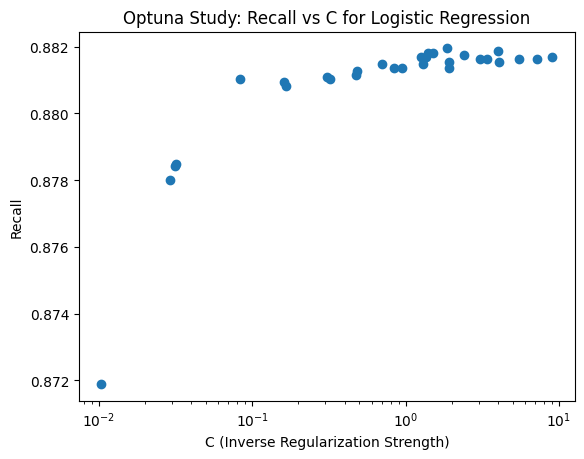

In [ ]:
C_values = study_log_reg.trials_dataframe()["params_C"]
recall_values = study_log_reg.trials_dataframe()["value"]

plt.figure()
plt.scatter(C_values, recall_values)
plt.xscale("log")
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("Recall")
plt.title("Optuna Study: Recall vs C for Logistic Regression")
plt.show()

## 5.8 Final Logistic Regression Pipeline Construction

In [ ]:
C = study_log_reg.best_params["C"]

In [ ]:
log_reg_pipeline = Pipeline([
        ("preprocess", preprocess_linear_2),
        ("model", LogisticRegression(
          C = C,
          penalty="l2",
          solver="lbfgs",
          class_weight="balanced",
          max_iter=10000,
          n_jobs=-1,
          random_state=108
))
    ])


In [ ]:
log_reg_pipeline.fit(X_train_2,y_train_2)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('pipe_gender',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 min_frequency=20,
                                                                                 sparse_output=False))]),
                                                  ['gender']),
                                                 ('pipe_ethnicity',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_...
                                                 ('pipe_waist_to_hip_ratio',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['waist_to_hip_ratio']),
                                                 ('pipe_diabetes_risk_score_pred',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['diabetes_risk_score_pred'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 LogisticRegression(C=1.854343446141166,
                                    class_weight='balanced', max_iter=10000,
                                    n_jobs=-1, random_state=108))])

##5.9 Model Evaluation on Test Data

In [ ]:
y_pred2_logreg = log_reg_pipeline.predict(X_test_2)

Classification report for Model : 
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      5980
           1       0.93      0.87      0.90      9020

    accuracy                           0.88     15000
   macro avg       0.88      0.89      0.88     15000
weighted avg       0.89      0.88      0.88     15000




Confusion Matrix for Model : 


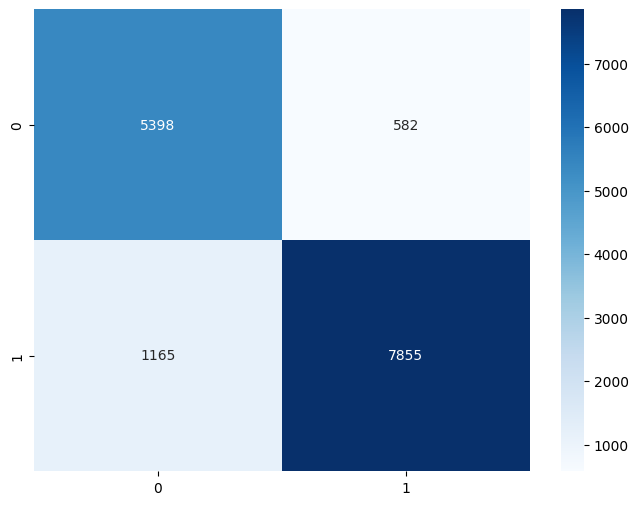

In [ ]:
print("Classification report for Model : ")
print(classification_report(y_test_2, y_pred2_logreg))
print("\n\n")

print("Confusion Matrix for Model : ")
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_2, y_pred2_logreg), annot=True, fmt='d', cmap='Blues')
plt.show()


In [ ]:
# probabilities for positive class
y_proba = log_reg_pipeline.predict_proba(X_test_2)[:, 1]

# PR-AUC (Average Precision)
pr_auc = average_precision_score(y_test_2, y_proba)

print(f"PR-AUC: {pr_auc:.4f}")


PR-AUC: 0.9657


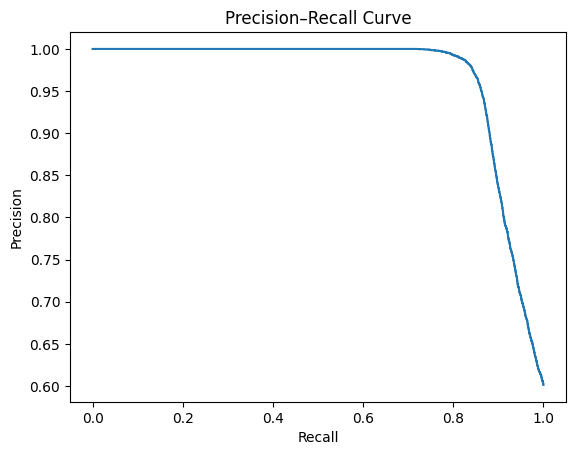

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test_2, y_proba)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()


##5.10  Feature Importance Analysis

In [ ]:
result = permutation_importance(
    log_reg_pipeline,
    X_test_2,
    y_test_2,
    n_repeats=10,
    scoring="recall",
    random_state=108,
    n_jobs=-1
)

perm_importance = pd.DataFrame({
    "feature": X_test_2.columns,
    "importance": result.importances_mean
}).sort_values("importance", ascending=False)

perm_importance


,feature,importance
27,hba1c,0.282816
24,glucose_fasting,0.000632
20,cholesterol_total,0.000277
8,physical_activity_minutes_per_week,0.000255
18,diastolic_bp,0.000166
19,heart_rate,0.000111
1,gender,0.000055
25,glucose_postprandial,0.000022
13,hypertension_history,0.000022
23,triglycerides,0.000011


##5.11 Final Model Training and Saving

In [ ]:
log_reg_pipeline.fit(X_2,y_2)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('pipe_gender',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 min_frequency=20,
                                                                                 sparse_output=False))]),
                                                  ['gender']),
                                                 ('pipe_ethnicity',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_...
                                                 ('pipe_waist_to_hip_ratio',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['waist_to_hip_ratio']),
                                                 ('pipe_diabetes_risk_score_pred',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['diabetes_risk_score_pred'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 LogisticRegression(C=1.854343446141166,
                                    class_weight='balanced', max_iter=10000,
                                    n_jobs=-1, random_state=108))])

In [ ]:
joblib.dump(log_reg_pipeline, "diagnosed_diabetes_model_log_reg.pkl")


['diagnosed_diabetes_model_log_reg.pkl']

# 6. Diabetes Type Prediction

##6.1 Out-of-Fold Probability Generation Function

In [ ]:
def generate_oof_probabilities_binary(
    pipeline,
    X: pd.DataFrame,
    y: pd.Series,
    n_splits: int = 5,
    random_state: int = 108
):
    """
    Generate out-of-fold predicted probabilities for binary classification.
    Returns probability of positive class.
    """

    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    oof_probs = np.zeros(len(X))

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]

        model = clone(pipeline)
        model.fit(X_train_fold, y_train_fold)

        oof_probs[val_idx] = model.predict_proba(X_val_fold)[:, 1]

    return pd.Series(oof_probs, index=X.index, name="diagnosed_diabetes_prob")


##6.2 Generating Out-of-Fold Probabilities

In [ ]:
diagnosed_diabetes_prob = generate_oof_probabilities_binary(
    pipeline=log_reg_pipeline,
    X=X_2,
    y=y_2
)

In [ ]:
df['diagnosed_diabetes_prob'] = diagnosed_diabetes_prob
df['diabetes_risk_score_pred'] = risk_oof
df.head()

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes,diagnosed_diabetes_prob,diabetes_risk_score_pred
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,145,136,236,6.36,8.18,29.6,Type 2,1,0.999403,28.419705
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,30,93,150,2.00,5.63,23.0,No Diabetes,0,0.034721,23.630279
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,36,118,195,5.07,7.51,44.7,Type 2,1,0.991989,45.959319
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,140,139,253,5.28,9.03,38.2,Type 2,1,0.999978,37.476317
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,160,137,184,12.74,7.20,23.5,Type 2,1,0.968437,22.928353


In [ ]:
df = df.drop(columns=['diabetes_risk_score'])

In [ ]:
df_3 = df[df['diagnosed_diabetes'] == 1]
df_3.head()

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_stage,diagnosed_diabetes,diagnosed_diabetes_prob,diabetes_risk_score_pred
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,160,145,136,236,6.36,8.18,Type 2,1,0.999403,28.419705
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,99,36,118,195,5.07,7.51,Type 2,1,0.991989,45.959319
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,79,140,139,253,5.28,9.03,Type 2,1,0.999978,37.476317
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,125,160,137,184,12.74,7.20,Type 2,1,0.968437,22.928353
7,62,Male,White,Postgraduate,Middle,Unemployed,Current,1,75,4.1,...,159,120,110,189,8.96,7.04,Type 2,1,0.932655,33.456329


In [ ]:
df_3.shape

(59998, 32)

##6.3 Data Preparation for Diabetes Type Prediction

In [ ]:
X_3 = df_3.drop(columns=['diabetes_stage','diagnosed_diabetes'])
y_3 = df_3['diabetes_stage']

In [ ]:
le = LabelEncoder()
y_3 = pd.Series(le.fit_transform(y_3))

In [ ]:
X_train_3,X_test_3,y_train_3,y_test_3 = train_test_split(X_3,y_3,
                                                         test_size=0.15,
                                                         stratify=y_3,
                                                         random_state=108)

##6.4 Initial Model Training and Evaluation

In [ ]:
X_train_3_subset, _, y_train_3_subset, _ = train_test_split(
    X_train_3, y_train_3,
    train_size=15000,
    stratify=y_train_3,
    random_state=108)

In [ ]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=108
)

models = {
    "LogisticRegression": Pipeline([
        ("preprocess", preprocess_linear_2),
        ("model", LogisticRegression(
            multi_class="multinomial",
            solver="lbfgs",
            class_weight="balanced",
            max_iter=5000,
            random_state=108
        ))
    ]),

    "RandomForest": Pipeline([
        ("preprocess", preprocess_linear_2),
        ("model", RandomForestClassifier(
            n_estimators=300,
            class_weight="balanced",
            n_jobs=-1,
            random_state=108
        ))
    ]),

    "GradientBoosting": Pipeline([
        ("preprocess", preprocess_linear_2),
        ("model", GradientBoostingClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=2,
            random_state=108
        ))
    ]),

    "XGBoost": Pipeline([
        ("preprocess", preprocess_linear_2),
        ("model", XGBClassifier(
            objective="multi:softprob",
            num_class=len(np.unique(y_train_3_subset)),
            eval_metric="mlogloss",
            n_estimators=300,
            learning_rate=0.05,
            max_depth=2,
            subsample=0.8,
            colsample_bytree=0.8,
            n_jobs=-1,
            random_state=108
        ))
    ])
}

results = {}

for name, pipeline in models.items():
    score = cross_val_score(
        pipeline,
        X_train_3_subset,
        y_train_3_subset,
        cv=cv,
        scoring="recall_macro",
        n_jobs=-1
    ).mean()

    results[name] = round(float(score),4)

results


{'LogisticRegression': 0.4863,
 'RandomForest': 0.3333,
 'GradientBoosting': 0.3331,
 'XGBoost': 0.3333}

##6.5 Hyperparameter Optimization for Diabetes Type Prediction Using Optuna

In [ ]:
def objective_logreg_model3(trial):

    C = trial.suggest_float("C", 0.01, 10.0, log=True)

    model = LogisticRegression(
        C=C,
        solver="lbfgs",
        class_weight="balanced",
        max_iter=5000,
        random_state=108
    )

    pipeline = Pipeline([
        ("preprocess", preprocess_linear_2),
        ("model", model)
    ])

    score = cross_val_score(
        pipeline,
        X_train_3_subset,
        y_train_3_subset,
        cv=StratifiedKFold(
            n_splits=5,
            shuffle=True,
            random_state=108
        ),
        scoring="recall_macro",
        n_jobs=-1
    ).mean()

    return score


In [ ]:
study_log_reg_3 = optuna.create_study(direction="maximize",study_name = 'log_reg_model3_study')
study_log_reg_3.optimize(objective_logreg_model3, n_trials=30)


[I 2025-12-26 12:02:38,729] A new study created in memory with name: log_reg_model3_study
[I 2025-12-26 12:04:00,145] Trial 0 finished with value: 0.5515267344236616 and parameters: {'C': 0.015219426833488063}. Best is trial 0 with value: 0.5515267344236616.
[I 2025-12-26 12:05:20,603] Trial 1 finished with value: 0.5176653866497551 and parameters: {'C': 0.29153151867749666}. Best is trial 0 with value: 0.5515267344236616.
[I 2025-12-26 12:06:41,716] Trial 2 finished with value: 0.5190981426915796 and parameters: {'C': 0.06334819120258131}. Best is trial 0 with value: 0.5515267344236616.
[I 2025-12-26 12:08:02,900] Trial 3 finished with value: 0.5226975035191508 and parameters: {'C': 0.1034584331987996}. Best is trial 0 with value: 0.5515267344236616.
[I 2025-12-26 12:09:23,039] Trial 4 finished with value: 0.47098893697536515 and parameters: {'C': 8.974896322263769}. Best is trial 0 with value: 0.5515267344236616.
[I 2025-12-26 12:10:43,351] Trial 5 finished with value: 0.487142589166

##6.6 Optuna Study Results Visualization

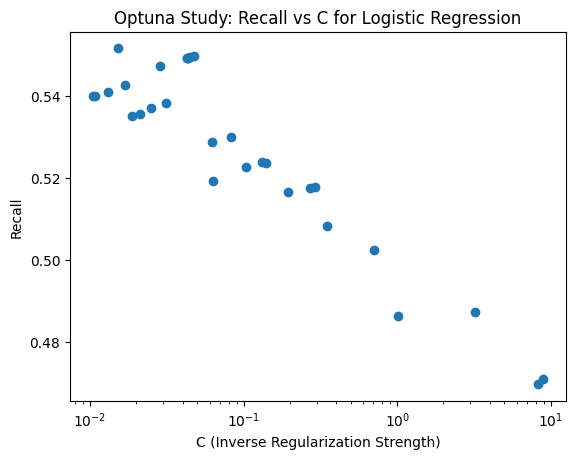

In [ ]:
C_values = study_log_reg_3.trials_dataframe()["params_C"]
recall_values = study_log_reg_3.trials_dataframe()["value"]

plt.figure()
plt.scatter(C_values, recall_values)
plt.xscale("log")
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("Recall")
plt.title("Optuna Study: Recall vs C for Logistic Regression")
plt.show()

##6.7 Final Diabetes Type Prediction Pipeline Construction

In [ ]:
C_3 = study_log_reg_3.best_params["C"]

In [ ]:
log_reg_pipeline_model3 = Pipeline([
        ("preprocess", preprocess_linear_2),
        ("model", LogisticRegression(
          C = C_3,
          solver="lbfgs",
          class_weight="balanced",
          max_iter=20000,
          random_state=108,
          n_jobs=-1
)) ])

In [ ]:
log_reg_pipeline_model3.fit(X_train_3,y_train_3)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('pipe_gender',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 min_frequency=20,
                                                                                 sparse_output=False))]),
                                                  ['gender']),
                                                 ('pipe_ethnicity',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_...
                                                 ('pipe_waist_to_hip_ratio',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['waist_to_hip_ratio']),
                                                 ('pipe_diabetes_risk_score_pred',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['diabetes_risk_score_pred'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 LogisticRegression(C=0.015219426833488063,
                                    class_weight='balanced', max_iter=20000,
                                    n_jobs=-1, random_state=108))])

##6.8 Model Evaluation on Test Data

In [ ]:
y_pred_3 = log_reg_pipeline_model3.predict(X_test_3)

In [ ]:
y_proba_3 = log_reg_pipeline_model3.predict_proba(X_test_3)


In [ ]:
print(
    classification_report(
        y_test_3,
        y_pred_3,
        target_names=le.classes_,
        digits=3
    )
)

              precision    recall  f1-score   support

 Gestational      0.014     0.792     0.028        24
      Type 1      0.004     0.500     0.009        10
      Type 2      0.999     0.728     0.843      8966

    accuracy                          0.728      9000
   macro avg      0.339     0.673     0.293      9000
weighted avg      0.996     0.728     0.839      9000



In [ ]:
macro_recall = recall_score(
    y_test_3,
    y_pred_3,
    average="macro"
)

print("Macro Recall:", macro_recall)

Macro Recall: 0.6732873571764939


In [ ]:
macro_f1 = f1_score(
    y_test_3,
    y_pred_3,
    average="macro"
)

print("Macro F1:", macro_f1)


Macro F1: 0.29310964446743176


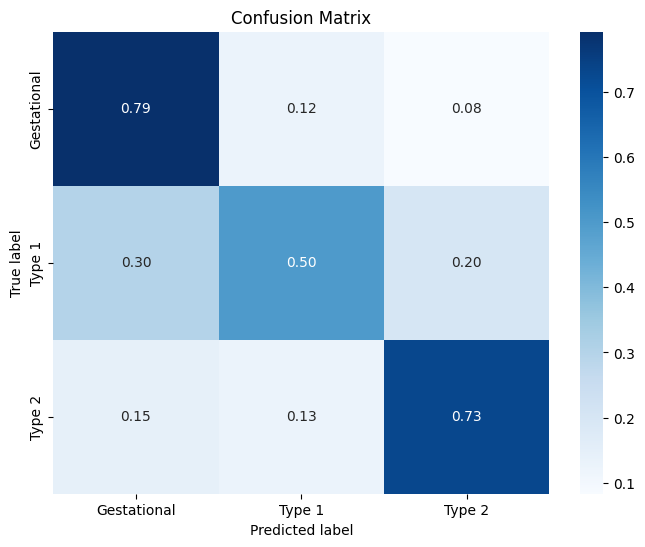

In [ ]:
cm_norm = confusion_matrix(y_test_3, y_pred_3, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
pr_auc_macro = average_precision_score(
    y_test_3,
    y_proba_3,
    average="macro"
)

print("Macro PR-AUC:", pr_auc_macro)


Macro PR-AUC: 0.3394366003850365


##6.9 Final Model Training and Saving

In [ ]:
log_reg_pipeline_model3.fit(X_3,y_3)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('pipe_gender',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 min_frequency=20,
                                                                                 sparse_output=False))]),
                                                  ['gender']),
                                                 ('pipe_ethnicity',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_...
                                                 ('pipe_waist_to_hip_ratio',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['waist_to_hip_ratio']),
                                                 ('pipe_diabetes_risk_score_pred',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['diabetes_risk_score_pred'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 LogisticRegression(C=0.015219426833488063,
                                    class_weight='balanced', max_iter=20000,
                                    n_jobs=-1, random_state=108))])

In [ ]:
joblib.dump(log_reg_pipeline_model3,"diagnosed_diabetes_type_log_reg_model.pkl")

['diagnosed_diabetes_type_log_reg_model.pkl']